In [1]:
# Day-Results

In [2]:
# import libs
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np
import pandas as pd
from functools import reduce
from mpl_toolkits.mplot3d import Axes3D
import math
import json
from pandas.io.json import json_normalize
import glob
from datetime import datetime
import os

In [3]:
# set some pandas plotting params
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
# define files to analyze
filesToAnalyze = [
    "bitcoin",
    "ethereum",
    "litecoin",
    "eos",
    "bitcoin-cash",
    "ripple",
    "tron",
    "ethereum-classic",
    "bitcoin-cash-sv",
    "paxos-standard",
    "zcash",
    "stellar",
    "dash",
    "neo",
    "qtum",
    "binancecoin",
    "cosmos",
    "cardano",
    "monero",
    "huobi-token"
]

In [5]:
# define a getData method for querying the data from csv
def getData(from_date='01/01/2018',to_date='08/01/2019'):
    result = pd.DataFrame(pd.date_range(start=from_date, end=to_date), columns = ['time'])
    result = result.set_index('time')
    
    for fileName in filesToAnalyze:
        currency = fileName # file.split('.')[-2].split('/')[-1]
        data = pd.read_json("../project/coingecko-data/{0}.json".format(fileName))
        data = pd.DataFrame(data=data['prices'].tolist(), columns = ['time',currency])
        data['time'] = list(map(lambda a: datetime.fromtimestamp(a / 1000.0), data['time']))
        data = data.set_index('time')
        result = pd.merge(result, data, on='time', how='left')
    
    result = result.ffill()
    return result

In [6]:
# query the actual data
data = getData()

In [7]:
# define method for ploting correlation
def plotCorrelation(data, method='pearson'):
    f = plt.figure(figsize=(19, 15))
    plt.matshow(data.corr(method=method), fignum=f.number)
    plt.xticks(range(data.shape[1]), data.columns, fontsize=24, rotation=90)
    plt.yticks(range(data.shape[1]), data.columns, fontsize=24)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=24)

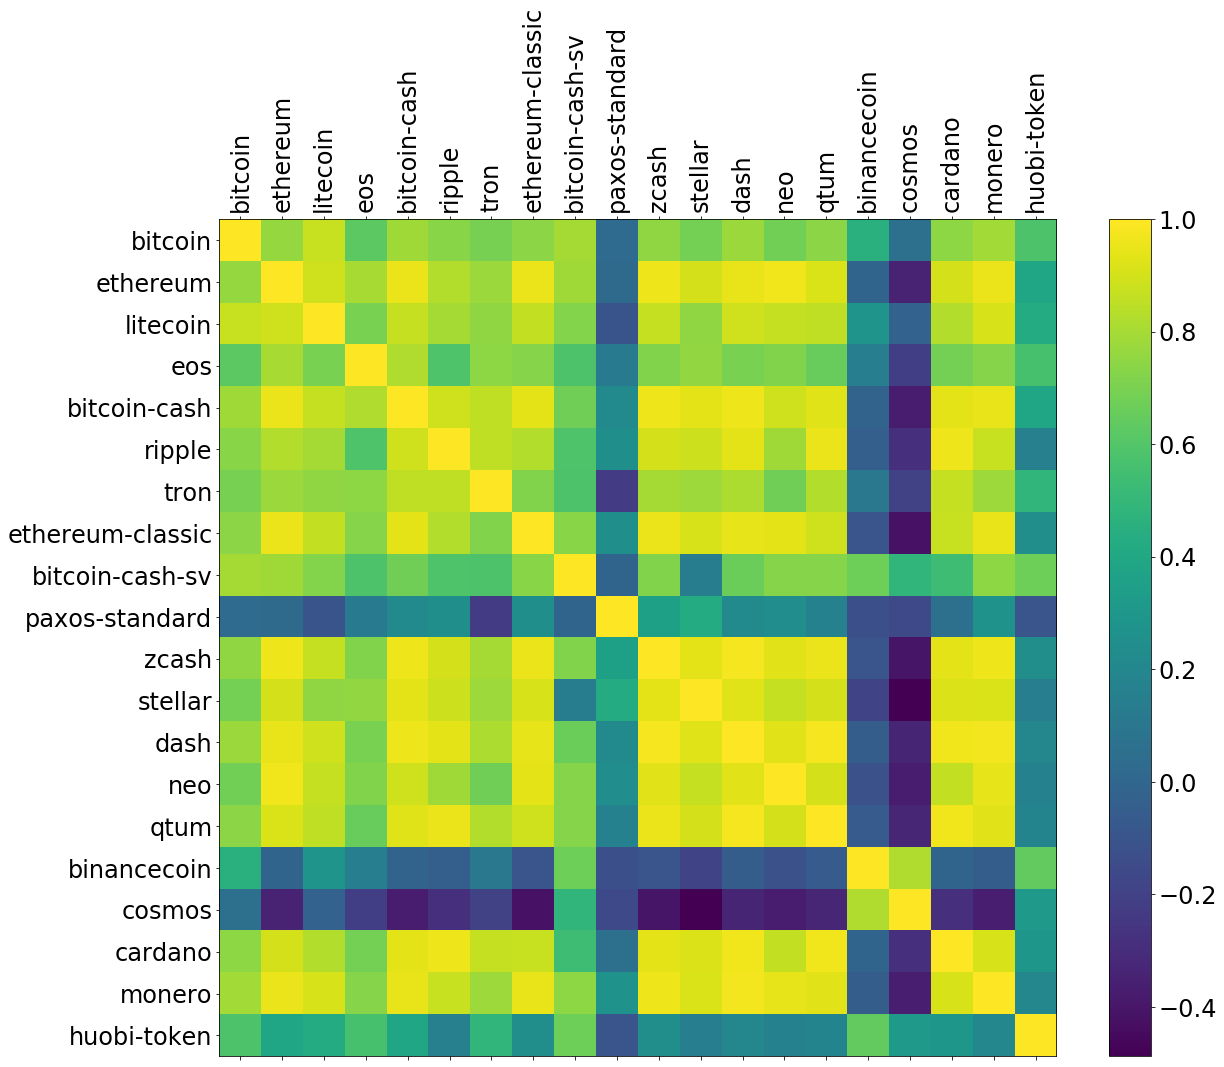

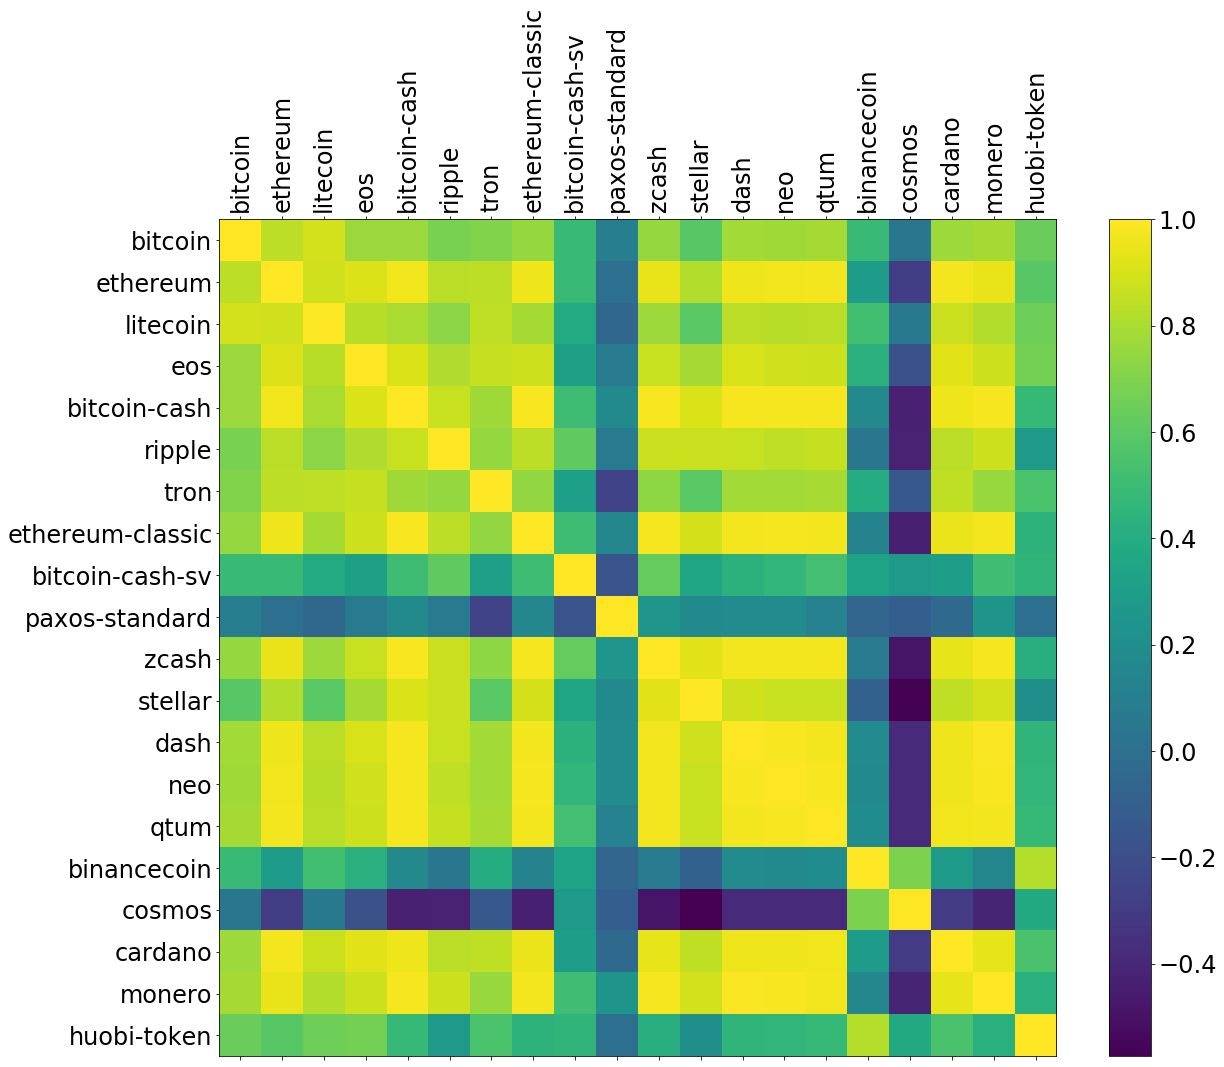

In [8]:
# first, investigate pearson and spearman correlation
# pearson
plotCorrelation(data)
# spearman
plotCorrelation(data, method='spearman')

In [9]:
# define profit and log profit methods
#profit
def profit(data):
    data = (data - data.shift(-1)) / data.shift(-1)
    return data
#log profit
def logProfit(data):
    data = np.log(data) - np.log(data.shift(-1))
    return data

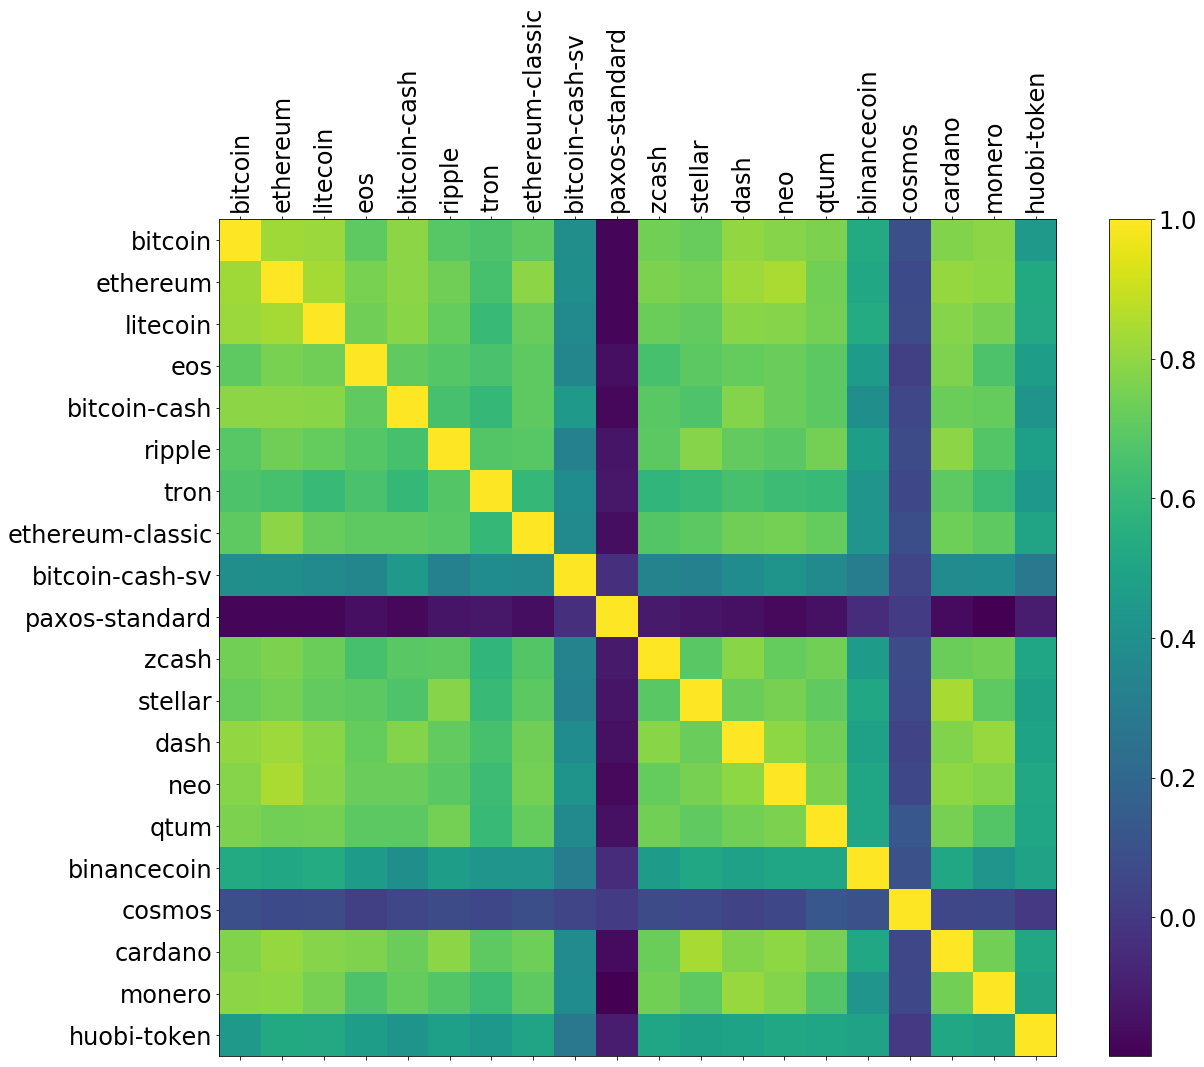

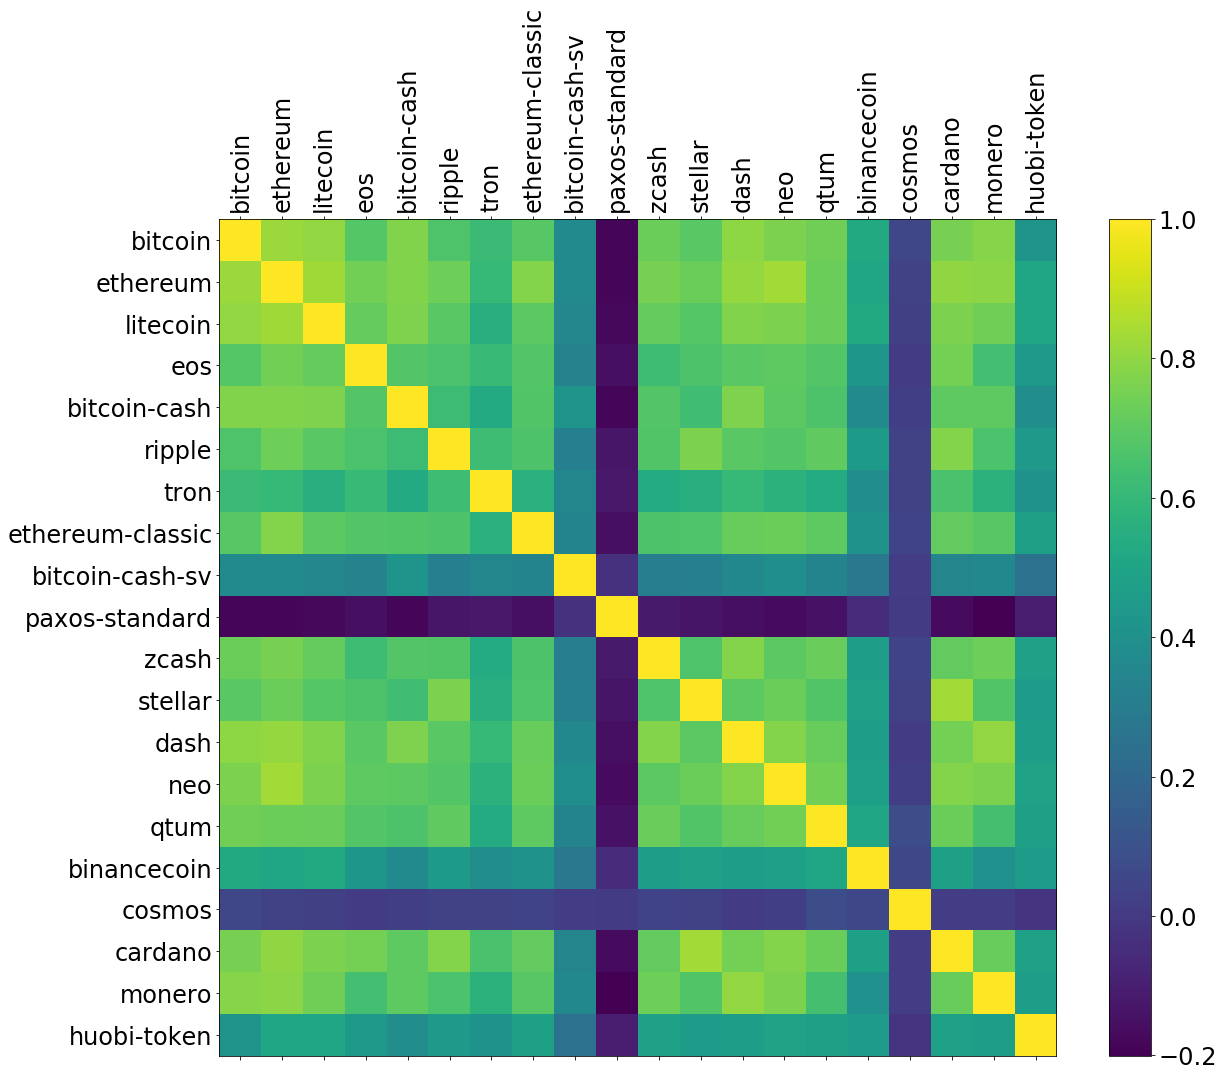

In [10]:
# second, investigate profit and log profit correlation with pearson correlation
#profit
plotCorrelation(profit(data))
#log profit
plotCorrelation(logProfit(data))

In [11]:
# define rolling correlation plot method
def plotRollingCorrelationChange(rollingValue, data):
    f = plt.figure(figsize=(19, 15))
    
    for entry in data:
        plt.plot(entry['firstData'].rolling(rollingValue).corr(entry['secondData'])[rollingValue:], label=entry['label'])
    
    plt.xticks(fontsize=24, rotation=90)
    plt.yticks(fontsize=24)

    plt.xlabel('Time', fontsize=24)
    plt.ylabel('Correlation', fontsize=24)

    plt.legend(fontsize=24)

    plt.show()

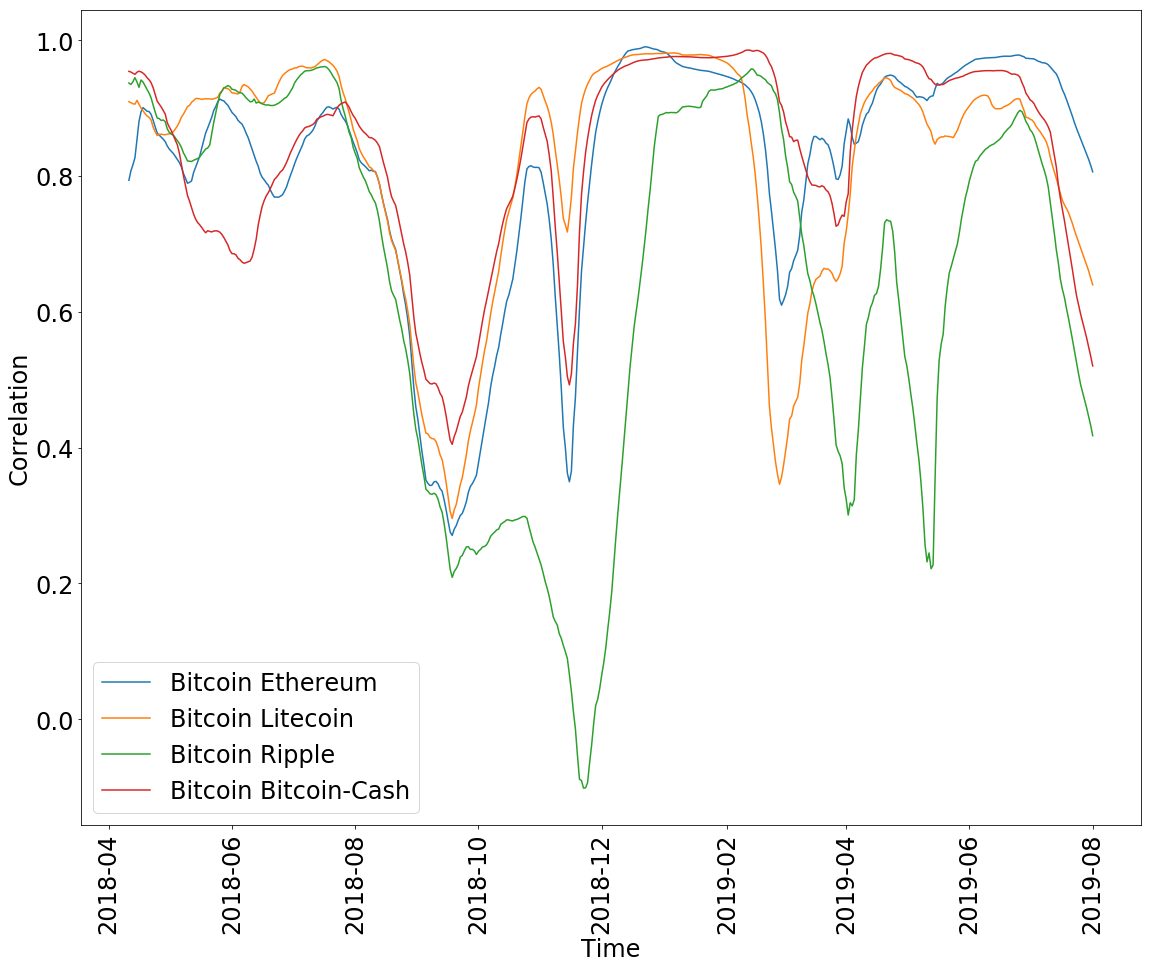

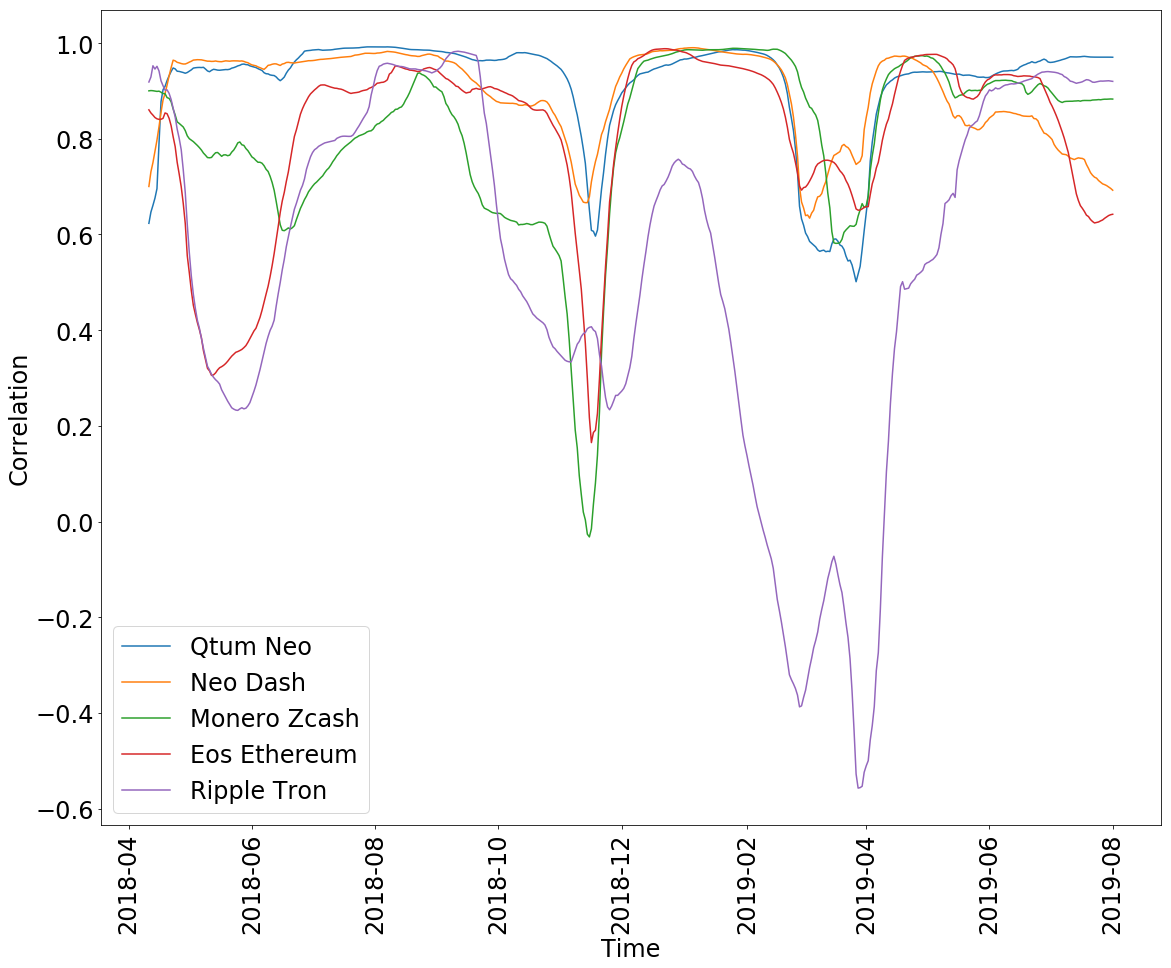

In [12]:
# third, investigate rolling correlation/correlation change
# correlation change of exchanges
plotRollingCorrelationChange(rollingValue=100,data=[
    {'label': 'Bitcoin Ethereum', 'firstData': data['bitcoin'], 'secondData': data['ethereum']},
    {'label': 'Bitcoin Litecoin', 'firstData': data['bitcoin'], 'secondData': data['litecoin']},
    {'label': 'Bitcoin Ripple', 'firstData': data['bitcoin'], 'secondData': data['ripple']},
    {'label': 'Bitcoin Bitcoin-Cash', 'firstData': data['bitcoin'], 'secondData': data['bitcoin-cash']}
])
# correlation of a selection of some altcoin combinations
plotRollingCorrelationChange(rollingValue=100,data=[
    {'label': 'Qtum Neo', 'firstData': data['qtum'], 'secondData': data['neo']},
    {'label': 'Neo Dash', 'firstData': data['neo'], 'secondData': data['dash']},
    {'label': 'Monero Zcash', 'firstData': data['monero'], 'secondData': data['zcash']},
    {'label': 'Eos Ethereum', 'firstData': data['eos'], 'secondData': data['ethereum']},
    {'label': 'Ripple Tron', 'firstData': data['ripple'], 'secondData': data['tron']},
])

In [13]:
# define plot method for 3d print of shifted correlation
def plotShiftedCorrelation(shiftRange, mainDataSource, comparingDataSources):
    correlations = []
    
    for column in comparingDataSources.columns:
        for forShiftRange in range(math.ceil(-shiftRange / 2), math.ceil(shiftRange / 2), 1):
            correlations.append(mainDataSource.shift(forShiftRange).corr(comparingDataSources[column]))
        
    fig = plt.figure(figsize=(19, 15))
    ax1 = fig.add_subplot(111, projection='3d')
    
    ypos = [x - 0.25 for x in list(range(math.ceil(-shiftRange / 2), math.ceil(shiftRange / 2), 1))] * len(comparingDataSources.columns)
    xpos = [int(x / shiftRange) - 0.025 for x in range(len(correlations))]
    zpos = [0] * len(correlations)

    dy = [0.5] * len(correlations)
    dx = [0.05] * len(correlations)
    dz = correlations

    def format_func(value, tick_number):
        if (value < len(comparingDataSources.columns)):
            return comparingDataSources.columns[int(value)]
        return value

    ax1.xaxis.set_major_formatter(plt.FuncFormatter(format_func))

    ax1.bar3d(xpos, ypos, zpos, dx, dy, dz, color='#00ceaa')

    ax1.set_ylabel('Time shift')
    ax1.set_zlabel('Correlatioin')

    ax1.view_init(30, 10)

    plt.show()

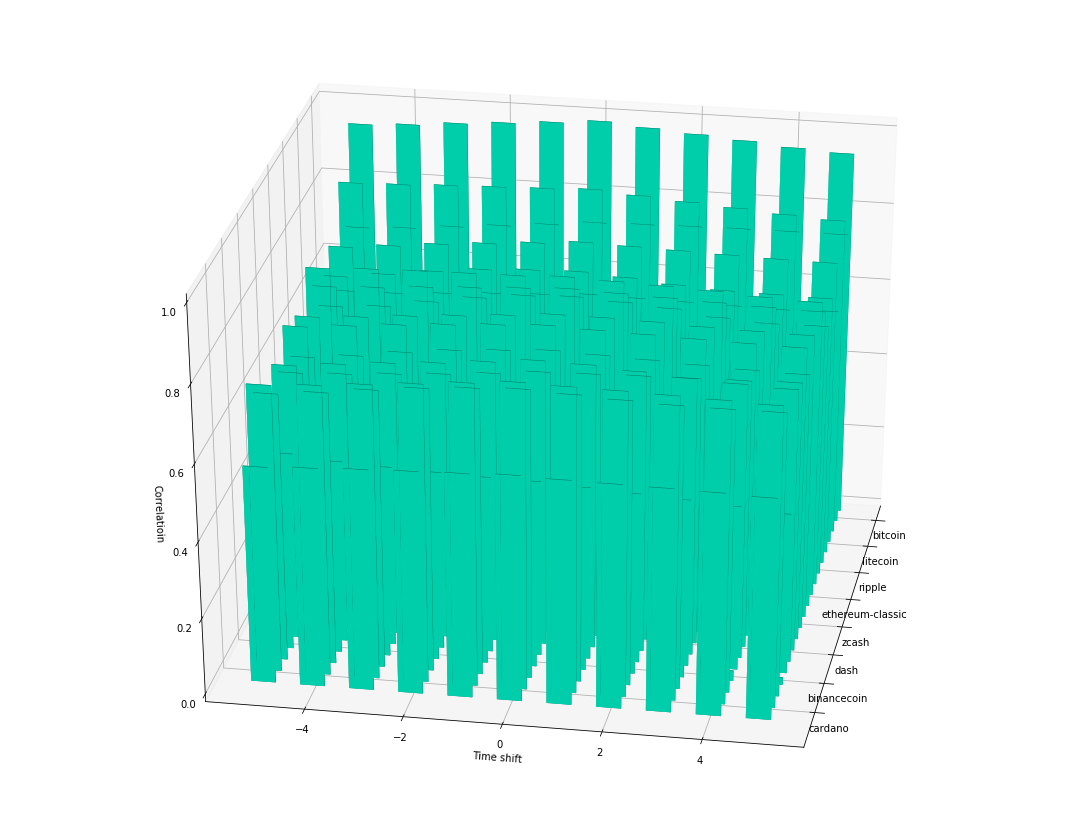

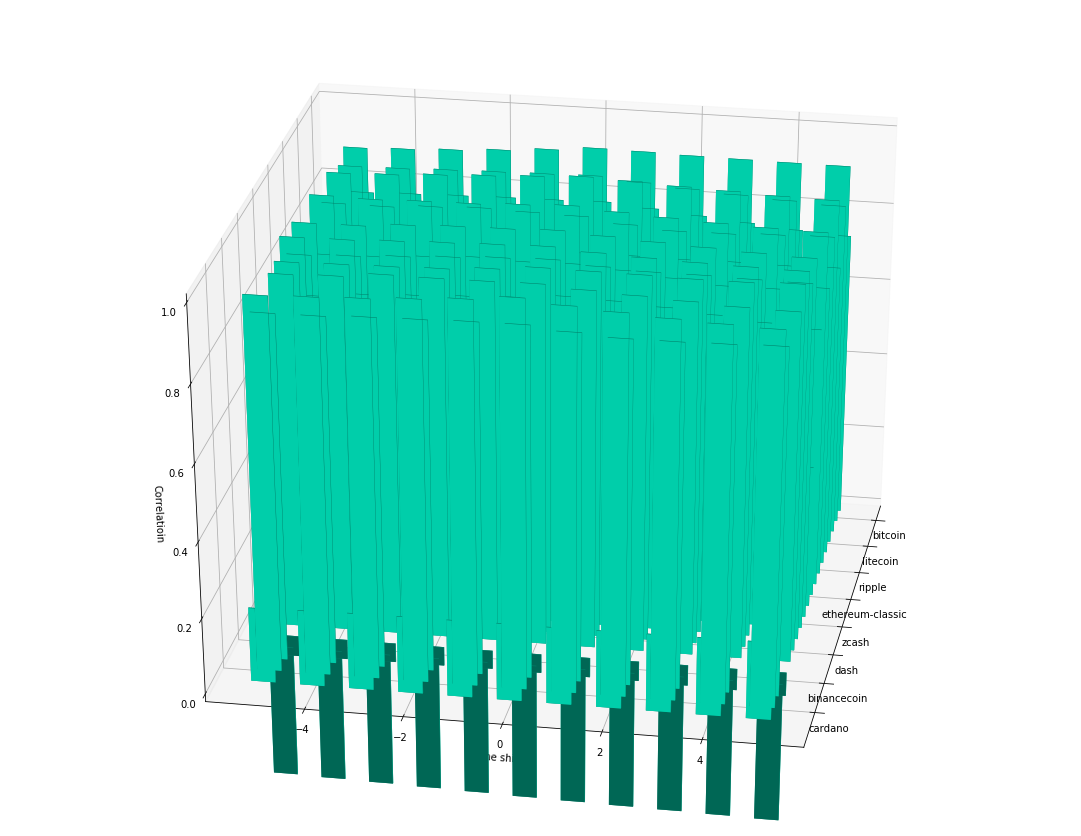

In [14]:
# fourth, investigate correlations in 3d matrix
# dayData bitcoin vs others
plotShiftedCorrelation(shiftRange=11,mainDataSource=data['bitcoin'],comparingDataSources=data)

# dayData monero vs others
plotShiftedCorrelation(shiftRange=11,mainDataSource=data['monero'],comparingDataSources=data)

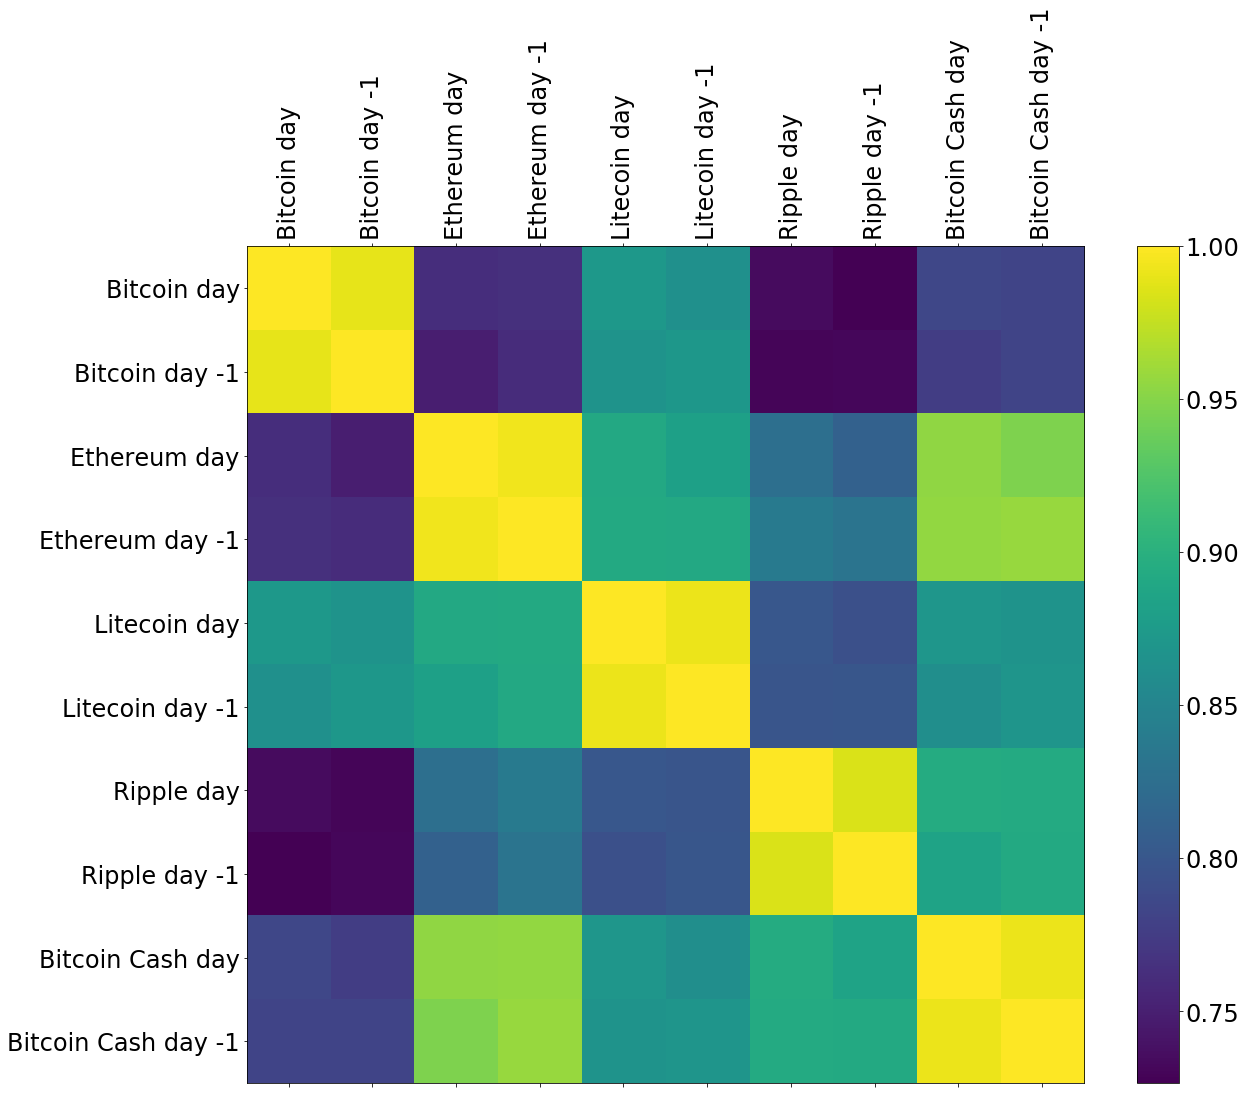

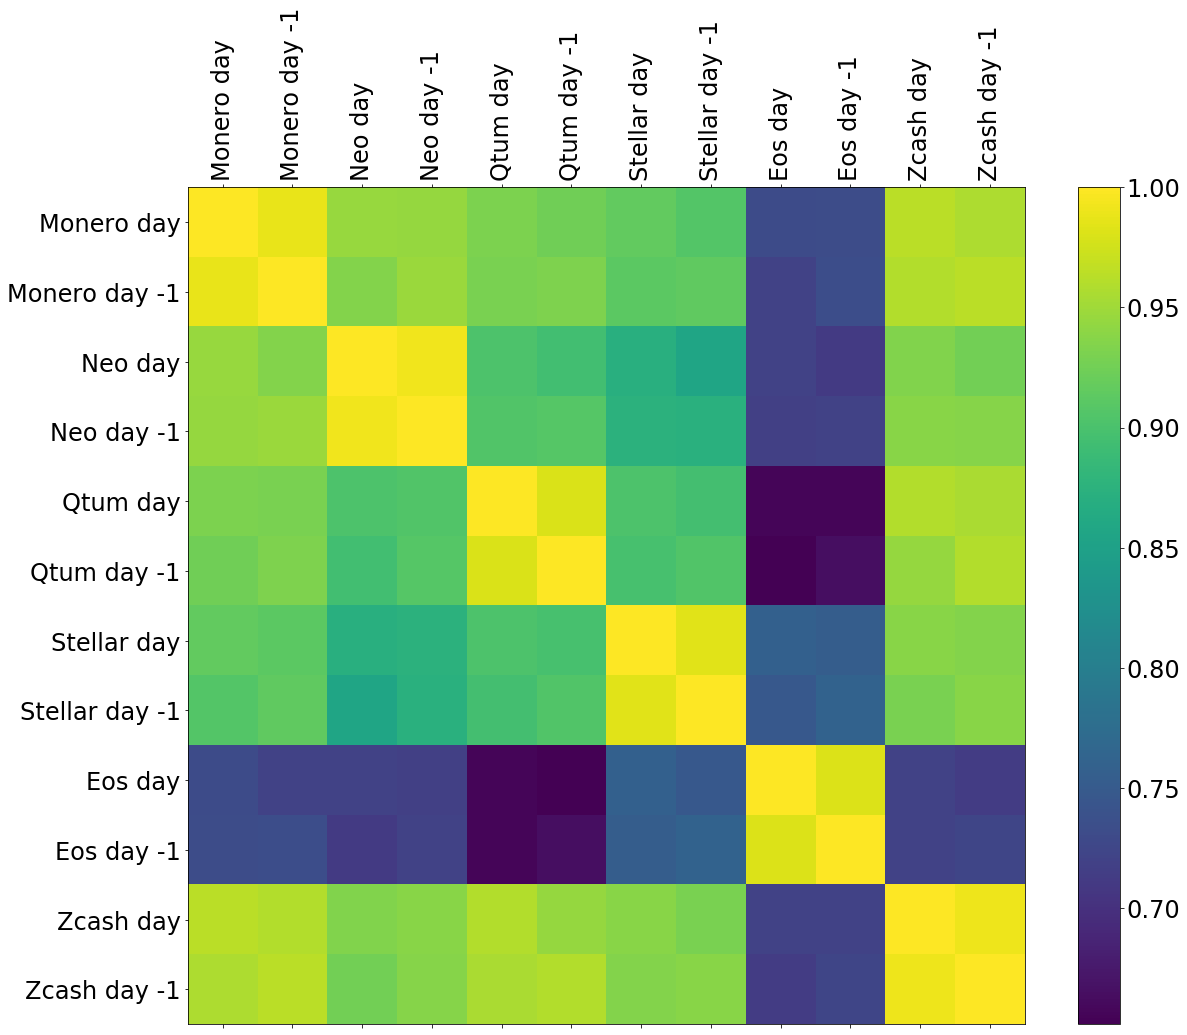

In [15]:
# fifth, compare a selection of shifted correlations

# dayData
selection = pd.DataFrame(np.array([
    data['bitcoin'],
    data['bitcoin'].shift(-1),
    data['ethereum'],
    data['ethereum'].shift(-1),
    data['litecoin'],
    data['litecoin'].shift(-1),
    data['ripple'],
    data['ripple'].shift(-1),
    data['bitcoin-cash'],
    data['bitcoin-cash'].shift(-1),
]).transpose(),
columns=[
    'Bitcoin day',
    'Bitcoin day -1',
    'Ethereum day',
    'Ethereum day -1',
    'Litecoin day',
    'Litecoin day -1',
    'Ripple day',
    'Ripple day -1',
    'Bitcoin Cash day',
    'Bitcoin Cash day -1'
],
index=data['bitcoin'].index)

f = plt.figure(figsize=(19, 15))
plt.matshow(selection.corr(), fignum=f.number)
plt.xticks(range(selection.shape[1]), selection.columns, fontsize=24, rotation=90)
plt.yticks(range(selection.shape[1]), selection.columns, fontsize=24)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=24)

# secondData
selection = pd.DataFrame(np.array([
    data['monero'],
    data['monero'].shift(-1),
    data['neo'],
    data['neo'].shift(-1),
    data['qtum'],
    data['qtum'].shift(-1),
    data['stellar'],
    data['stellar'].shift(-1),
    data['eos'],
    data['eos'].shift(-1),
    data['zcash'],
    data['zcash'].shift(-1),
]).transpose(),
columns=[
    'Monero day',
    'Monero day -1',
    'Neo day',
    'Neo day -1',
    'Qtum day',
    'Qtum day -1',
    'Stellar day',
    'Stellar day -1',
    'Eos day',
    'Eos day -1',
    'Zcash day',
    'Zcash day -1'
],
index=data['bitcoin'].index)

f = plt.figure(figsize=(19, 15))
plt.matshow(selection.corr(), fignum=f.number)
plt.xticks(range(selection.shape[1]), selection.columns, fontsize=24, rotation=90)
plt.yticks(range(selection.shape[1]), selection.columns, fontsize=24)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=24)

In [16]:
# ethereum and bitcoin-cash are looking promising for this analysis

In [17]:
# buy and hold strategy with ethereum
cryptoCurrencyData = data['ethereum']
print(100 / cryptoCurrencyData[0] * 0.998 * 0.999 * cryptoCurrencyData[-1])

28.0844230913


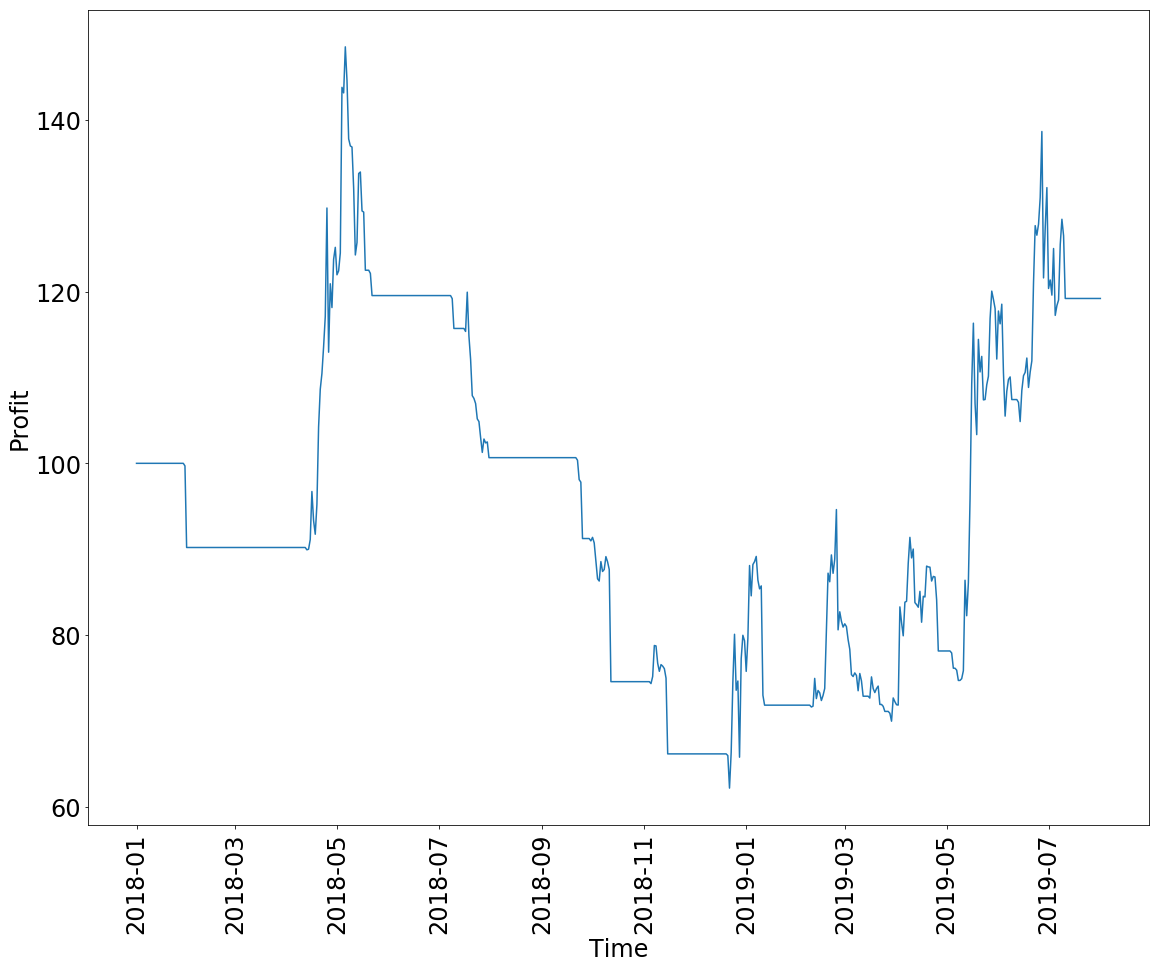

119.210222158


In [18]:
# algorithmic trading greedy approach with ethereum
# 30 day moving average is used like it is common in stock markets

dollar = 100
crypto = 0

cryptoCurrencyData = data['ethereum']

profitGraph = pd.DataFrame([], columns=['profit'], index=cryptoCurrencyData.index)

for index in cryptoCurrencyData.index:
    if (cryptoCurrencyData[index] > cryptoCurrencyData.rolling(30).mean()[index] and dollar != 0):
        crypto = dollar / cryptoCurrencyData[index] * 0.998
        dollar = 0

    if (cryptoCurrencyData[index] < cryptoCurrencyData.rolling(30).mean()[index] and crypto != 0):
        dollar = cryptoCurrencyData[index] * crypto * 0.999
        crypto = 0
        
    profitGraph['profit'][index] = dollar + cryptoCurrencyData[index] * crypto * 0.999

f = plt.figure(figsize=(19, 15))

plt.plot(profitGraph)

plt.xticks(fontsize=24, rotation=90)
plt.yticks(fontsize=24)

plt.xlabel('Time', fontsize=24)
plt.ylabel('Profit', fontsize=24)

plt.show()

print(profitGraph['profit'][-1])

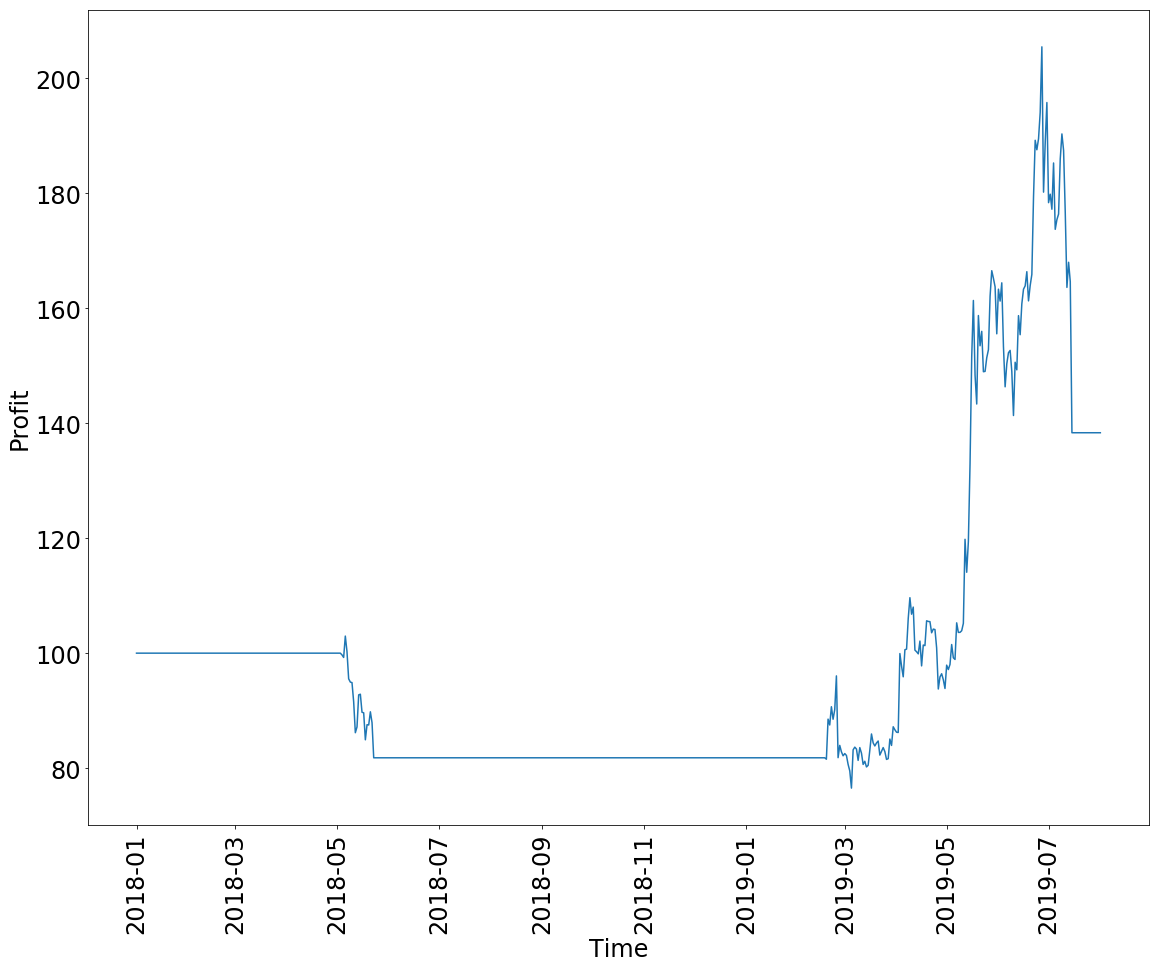

138.34682938


In [19]:
# algorithmic trading greedy approach with ethereum
# 100 day moving average is used like it is common in stock markets

dollar = 100
crypto = 0

cryptoCurrencyData = data['ethereum']

profitGraph = pd.DataFrame([], columns=['profit'], index=cryptoCurrencyData.index)

for index in cryptoCurrencyData.index:
    if (cryptoCurrencyData[index] > cryptoCurrencyData.rolling(100).mean()[index] and dollar != 0):
        crypto = dollar / cryptoCurrencyData[index] * 0.998
        dollar = 0

    if (cryptoCurrencyData[index] < cryptoCurrencyData.rolling(100).mean()[index] and crypto != 0):
        dollar = cryptoCurrencyData[index] * crypto * 0.999
        crypto = 0
        
    profitGraph['profit'][index] = dollar + cryptoCurrencyData[index] * crypto * 0.999

f = plt.figure(figsize=(19, 15))

plt.plot(profitGraph)

plt.xticks(fontsize=24, rotation=90)
plt.yticks(fontsize=24)

plt.xlabel('Time', fontsize=24)
plt.ylabel('Profit', fontsize=24)

plt.show()

print(profitGraph['profit'][-1])

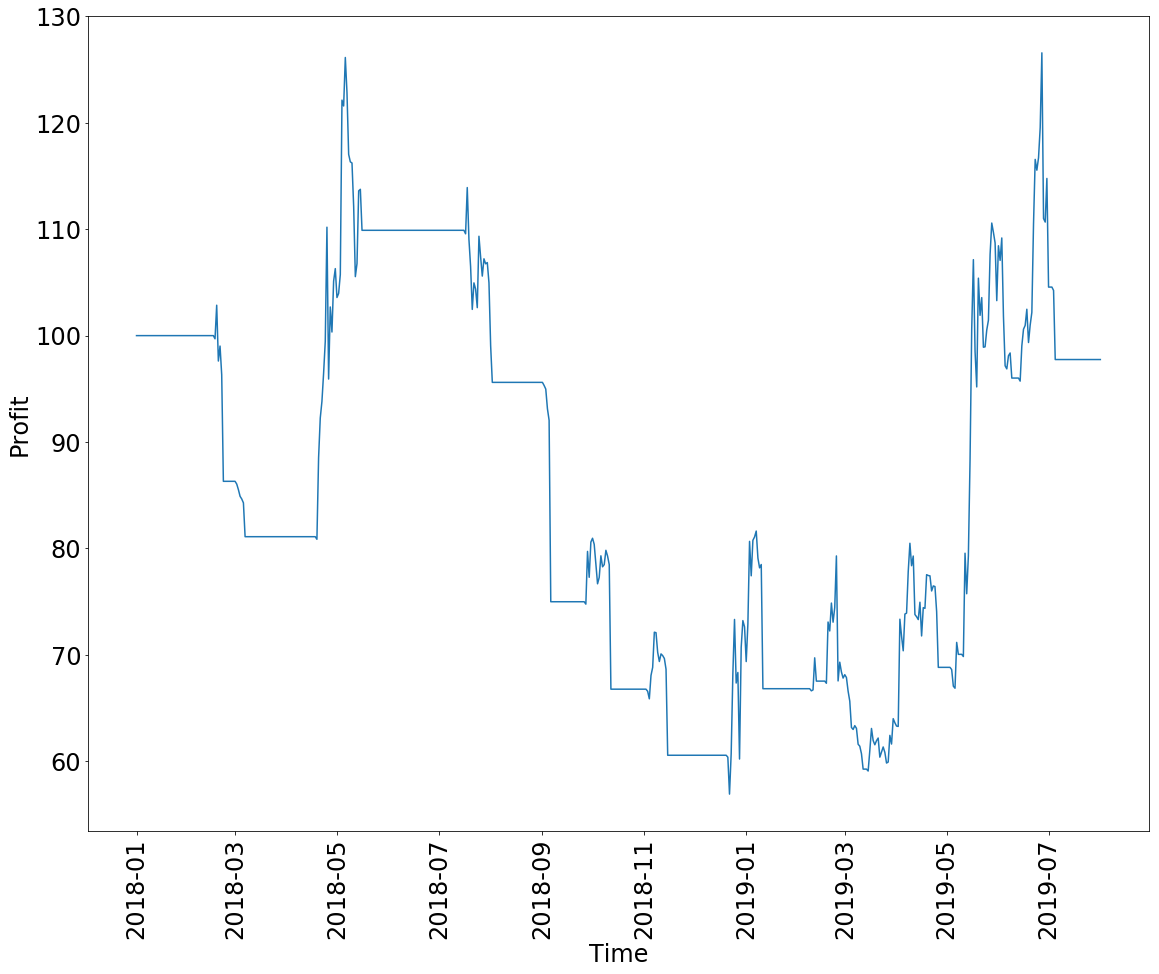

97.7526236723


In [20]:
# algorithmic lead-lag approach basic test without shift of bitcoin-cash signal
# 30 day moving average is used like it is common in stock markets

dollar = 100
crypto = 0

tradingData = data['ethereum']
signalData = data['bitcoin-cash']

profitGraph = pd.DataFrame([], columns=['profit'], index=tradingData.index)

for index in tradingData.index:
    if (signalData[index] > signalData.rolling(30).mean()[index] and dollar != 0):
        crypto = dollar / tradingData[index] * 0.998
        dollar = 0

    if (signalData[index] < signalData.rolling(30).mean()[index] and crypto != 0):
        dollar = tradingData[index] * crypto * 0.999
        crypto = 0

    profitGraph['profit'][index] = dollar + tradingData[index] * crypto * 0.999
        
f = plt.figure(figsize=(19, 15))

plt.plot(profitGraph)

plt.xticks(fontsize=24, rotation=90)
plt.yticks(fontsize=24)

plt.xlabel('Time', fontsize=24)
plt.ylabel('Profit', fontsize=24)

plt.show()

print(profitGraph['profit'][-1])

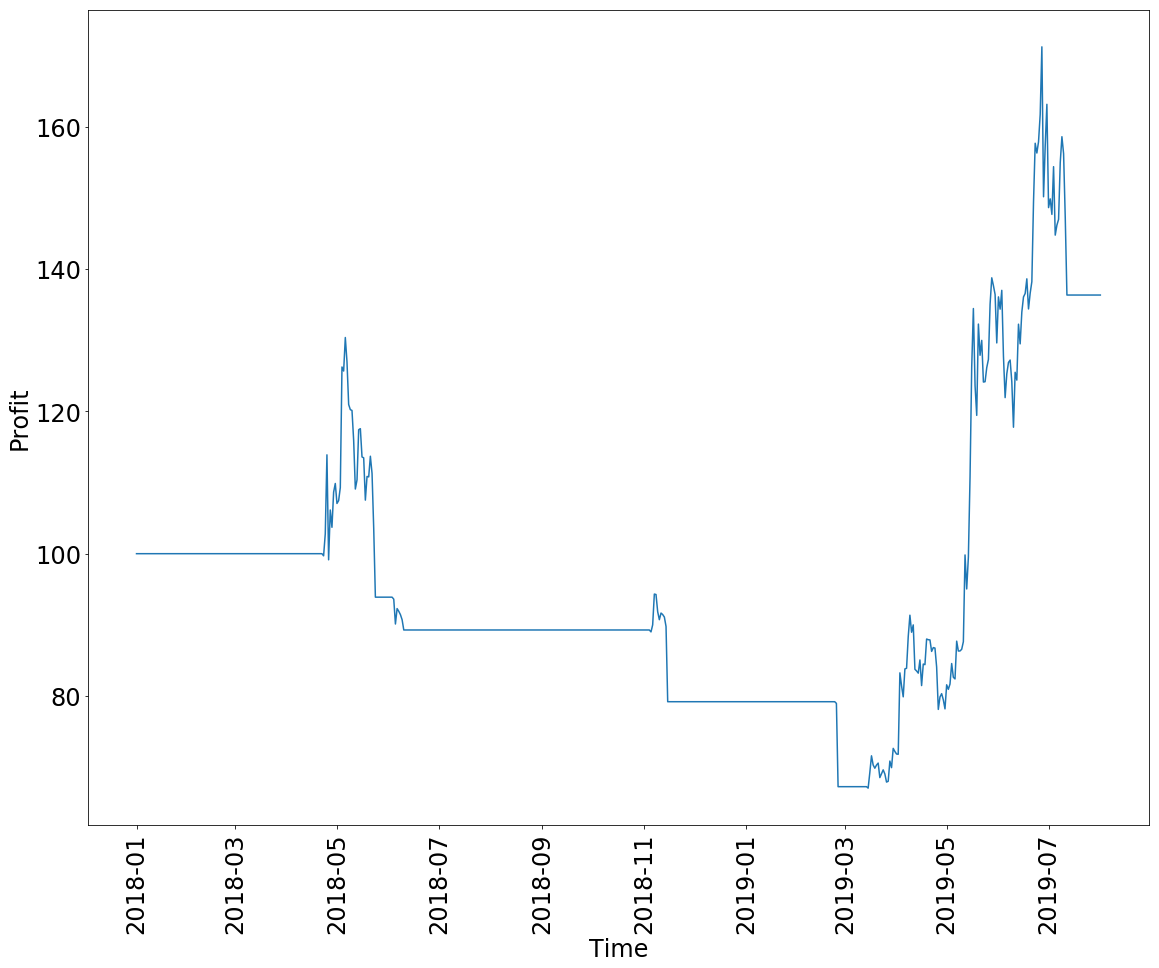

136.335834382


In [21]:
# algorithmic lead-lag approach basic test without shift of bitcoin-cash signal
# 100 day moving average is used like it is common in stock markets

dollar = 100
crypto = 0

tradingData = data['ethereum']
signalData = data['bitcoin-cash']

profitGraph = pd.DataFrame([], columns=['profit'], index=tradingData.index)

for index in tradingData.index:
    if (signalData[index] > signalData.rolling(100).mean()[index] and dollar != 0):
        crypto = dollar / tradingData[index] * 0.998
        dollar = 0

    if (signalData[index] < signalData.rolling(100).mean()[index] and crypto != 0):
        dollar = tradingData[index] * crypto * 0.999
        crypto = 0

    profitGraph['profit'][index] = dollar + tradingData[index] * crypto * 0.999
        
f = plt.figure(figsize=(19, 15))

plt.plot(profitGraph)

plt.xticks(fontsize=24, rotation=90)
plt.yticks(fontsize=24)

plt.xlabel('Time', fontsize=24)
plt.ylabel('Profit', fontsize=24)

plt.show()

print(profitGraph['profit'][-1])

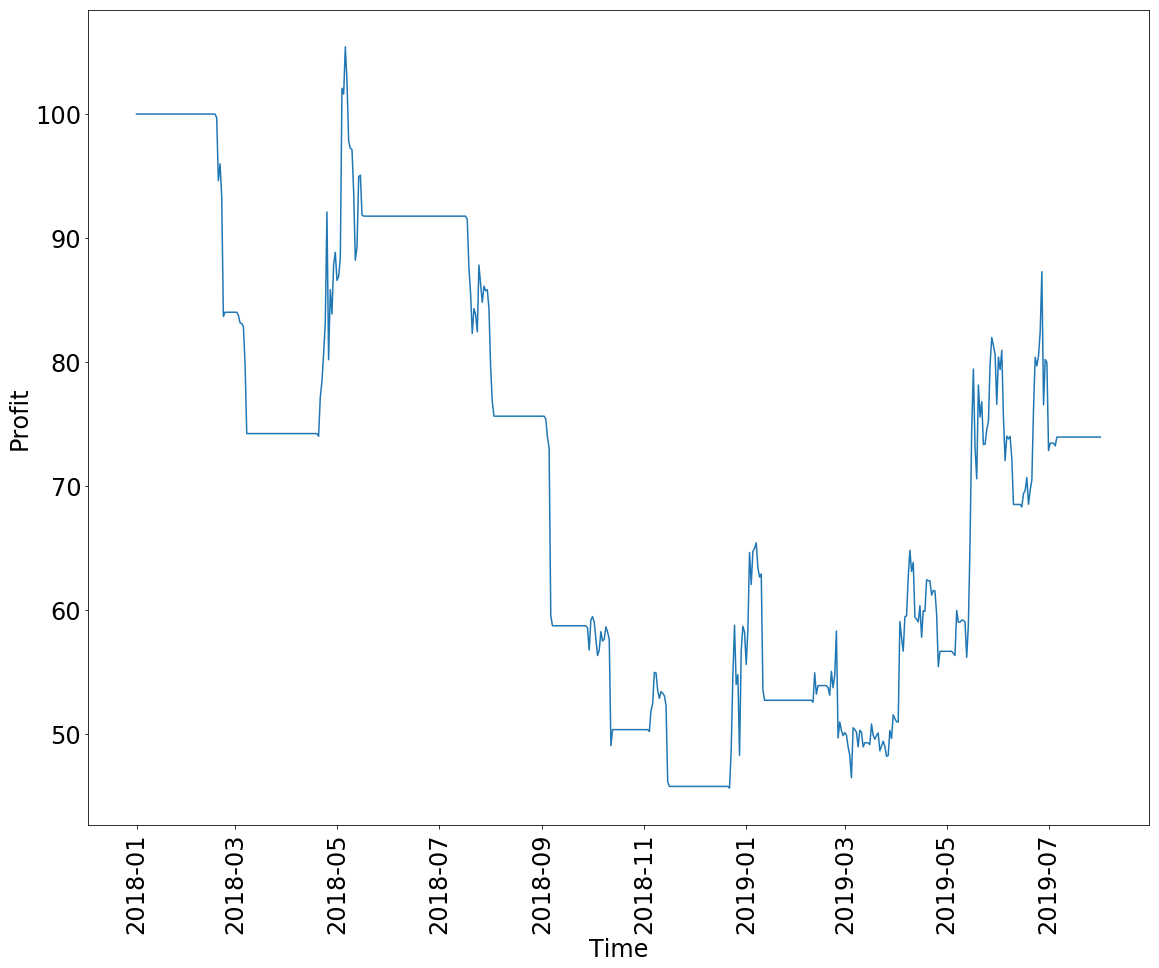

73.9285844688


In [22]:
# algorithmic lead-lag approach basic test with shift of bitcoin-cash signal
# 30 day moving average is used like it is common in stock markets

dollar = 100
crypto = 0

tradingData = data['ethereum']
signalData = data['bitcoin-cash'].shift(1)

profitGraph = pd.DataFrame([], columns=['profit'], index=tradingData.index)

for index in tradingData.index:
    if (signalData[index] > signalData.rolling(30).mean()[index] and dollar != 0):
        crypto = dollar / tradingData[index] * 0.998
        dollar = 0

    if (signalData[index] < signalData.rolling(30).mean()[index] and crypto != 0):
        dollar = tradingData[index] * crypto * 0.999
        crypto = 0

    profitGraph['profit'][index] = dollar + tradingData[index] * crypto * 0.999
        
f = plt.figure(figsize=(19, 15))

plt.plot(profitGraph)

plt.xticks(fontsize=24, rotation=90)
plt.yticks(fontsize=24)

plt.xlabel('Time', fontsize=24)
plt.ylabel('Profit', fontsize=24)

plt.show()

print(profitGraph['profit'][-1])

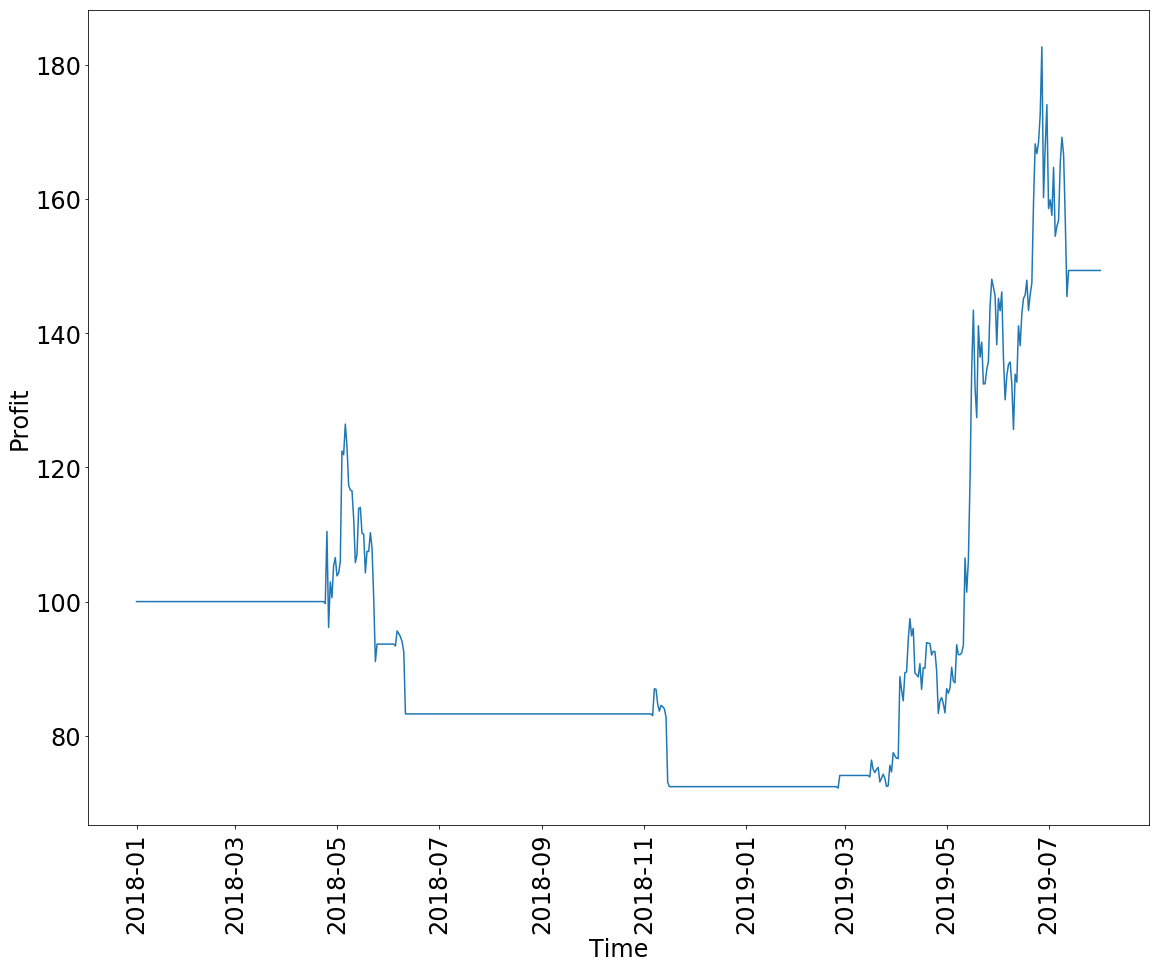

149.327238241


In [23]:
# algorithmic lead-lag approach basic test with shift of bitcoin-cash signal
# 100 day moving average is used like it is common in stock markets

dollar = 100
crypto = 0

tradingData = data['ethereum']
signalData = data['bitcoin-cash'].shift(1)

profitGraph = pd.DataFrame([], columns=['profit'], index=tradingData.index)

for index in tradingData.index:
    if (signalData[index] > signalData.rolling(100).mean()[index] and dollar != 0):
        crypto = dollar / tradingData[index] * 0.998
        dollar = 0

    if (signalData[index] < signalData.rolling(100).mean()[index] and crypto != 0):
        dollar = tradingData[index] * crypto * 0.999
        crypto = 0

    profitGraph['profit'][index] = dollar + tradingData[index] * crypto * 0.999
        
f = plt.figure(figsize=(19, 15))

plt.plot(profitGraph)

plt.xticks(fontsize=24, rotation=90)
plt.yticks(fontsize=24)

plt.xlabel('Time', fontsize=24)
plt.ylabel('Profit', fontsize=24)

plt.show()

print(profitGraph['profit'][-1])

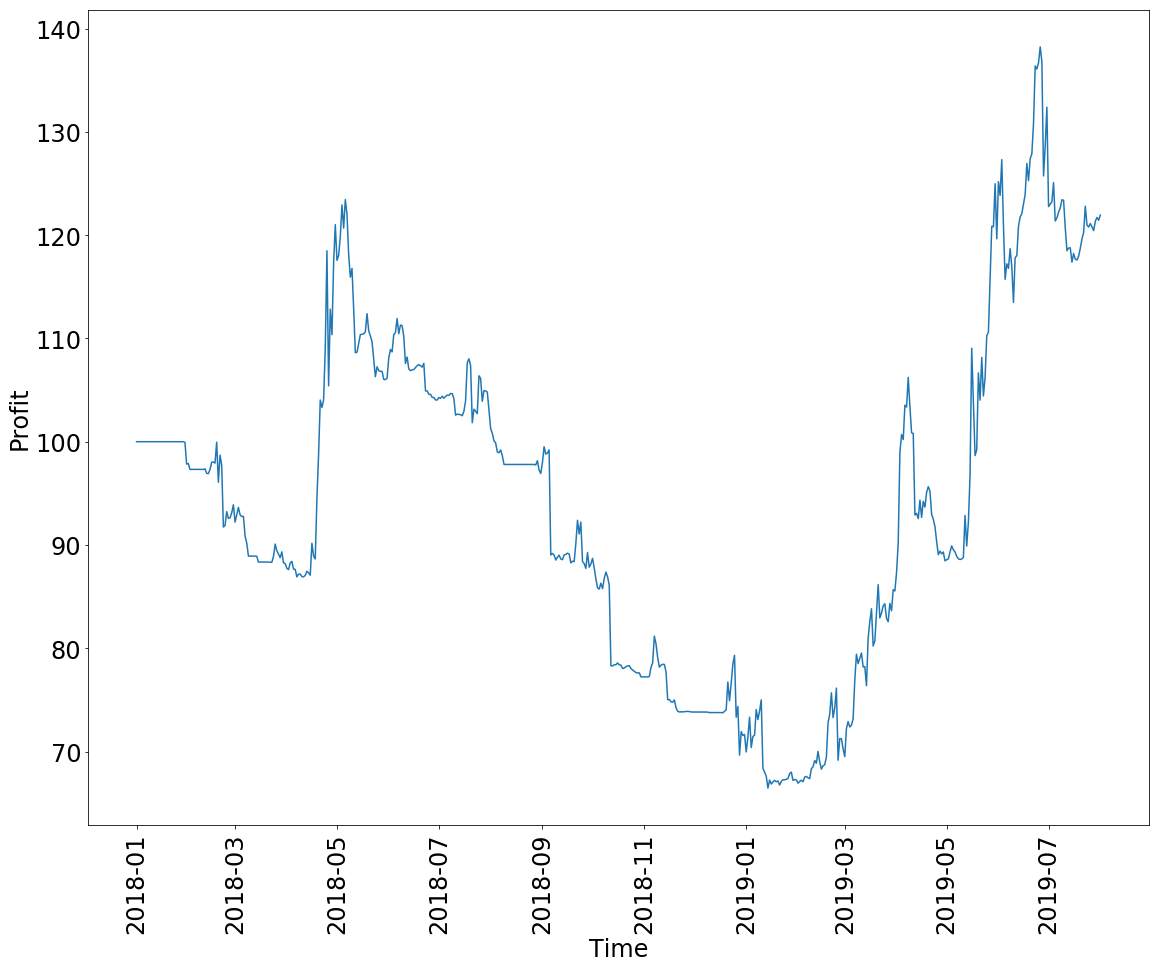

121.937476174


In [24]:
# extension of greedy approach if every of the 20 currency gets 5 dollars
# 30 day moving average is used like it is common in stock markets

dollar = {}
crypto = {}

for currency in data.columns:
    dollar[currency] = 5
    crypto[currency] = 0
    
profitGraph = pd.DataFrame(data=np.zeros(len(data)), columns=['profit'], index=data.index)

for currency in data.columns:
    selection = data[currency]
    for index in selection.index:
        if ((selection[index] > selection.rolling(30).mean()[index]) and (dollar[currency] != 0)):
            crypto[currency] = dollar[currency] / selection[index] * 0.998
            dollar[currency] = 0

        if ((selection[index] < selection.rolling(30).mean()[index]) and (crypto[currency] != 0)):
            dollar[currency] = selection[index] * crypto[currency] * 0.999
            crypto[currency] = 0

        profitGraph['profit'][index] += dollar[currency] + (0 if np.isnan(selection[index]) else selection[index]) * crypto[currency] * 0.999

f = plt.figure(figsize=(19, 15))

plt.plot(profitGraph)

plt.xticks(fontsize=24, rotation=90)
plt.yticks(fontsize=24)

plt.xlabel('Time', fontsize=24)
plt.ylabel('Profit', fontsize=24)

plt.show()

print(profitGraph['profit'][-1])

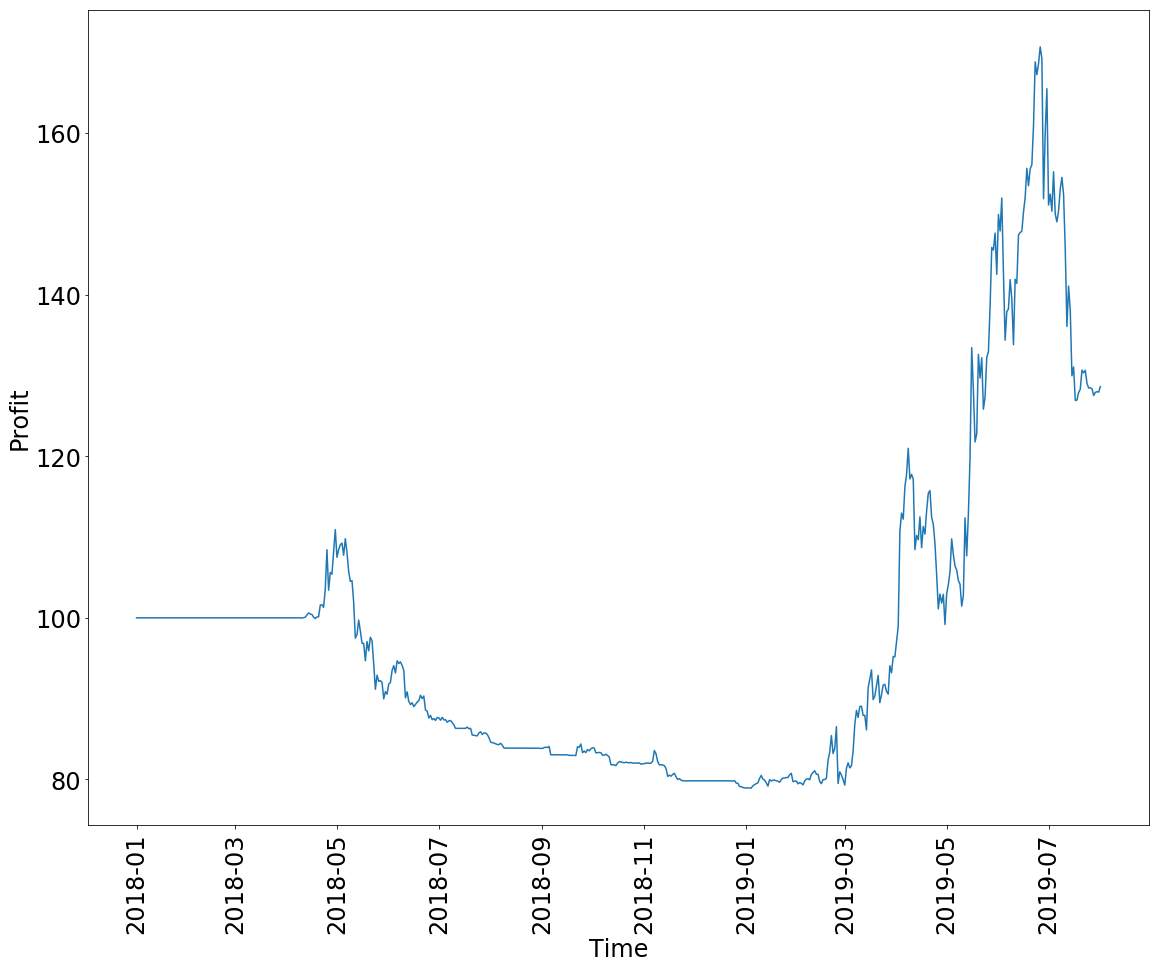

128.617807245


In [25]:
# extension of greedy approach if every of the 20 currency gets 5 dollars
# 100 day moving average is used like it is common in stock markets

dollar = {}
crypto = {}

for currency in data.columns:
    dollar[currency] = 5
    crypto[currency] = 0
    
profitGraph = pd.DataFrame(data=np.zeros(len(data)), columns=['profit'], index=data.index)

for currency in data.columns:
    selection = data[currency]
    for index in selection.index:
        if ((selection[index] > selection.rolling(100).mean()[index]) and (dollar[currency] != 0)):
            crypto[currency] = dollar[currency] / selection[index] * 0.998
            dollar[currency] = 0

        if ((selection[index] < selection.rolling(100).mean()[index]) and (crypto[currency] != 0)):
            dollar[currency] = selection[index] * crypto[currency] * 0.999
            crypto[currency] = 0

        profitGraph['profit'][index] += dollar[currency] + (0 if np.isnan(selection[index]) else selection[index]) * crypto[currency] * 0.999

f = plt.figure(figsize=(19, 15))

plt.plot(profitGraph)

plt.xticks(fontsize=24, rotation=90)
plt.yticks(fontsize=24)

plt.xlabel('Time', fontsize=24)
plt.ylabel('Profit', fontsize=24)

plt.show()

print(profitGraph['profit'][-1])

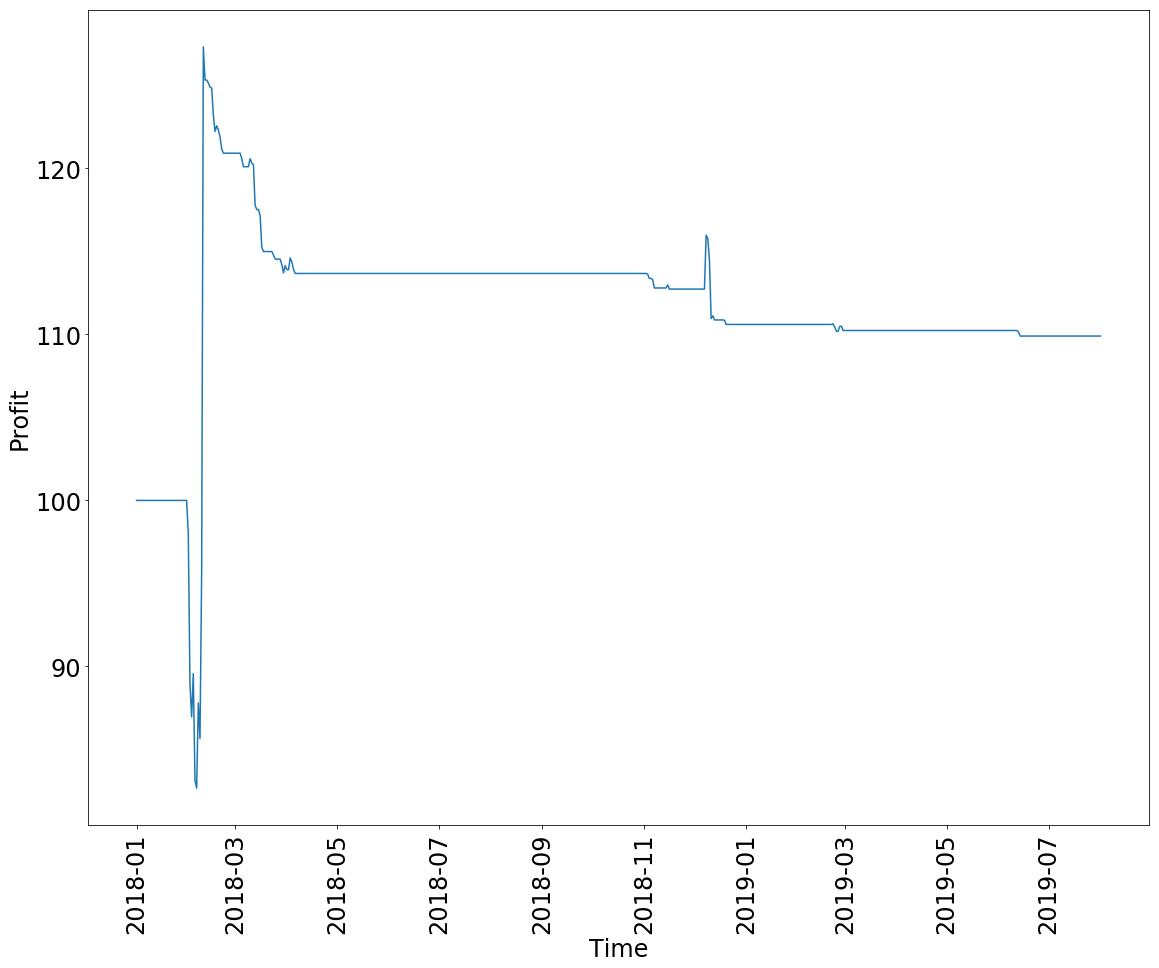

109.903149481


In [26]:
# now a algorithmus which calculates lead-lag correlation for every pair of currencies
# 30 day moving average is used like it is common in stock markets

dollar = 100
crypto = 0

correlationBookCrypto = {}
correlationBookDollar = {}

for currency1 in data.columns:
    correlationBookCrypto[currency1] = {}
    correlationBookDollar[currency1] = {}
    for currency2 in data.columns:
        correlationBookCrypto[currency1][currency2] = 0
        correlationBookDollar[currency1][currency2] = 0.25

rollingSignalCorrelation = data.rolling(30).corr()

profitGraph = pd.DataFrame(data=np.zeros(len(data)), columns=['profit'], index=data.index)

for index in data.index:
    for currency1 in rollingSignalCorrelation.columns:
        for currency2 in rollingSignalCorrelation.columns:
            if rollingSignalCorrelation[currency1][index][currency2] < rollingSignalCorrelation[currency2].shift(1)[index][currency1] and rollingSignalCorrelation[currency1][index][currency2] > 0 and (correlationBookDollar[currency1][currency2] != 0):
                if data[currency2][index] > data[currency2].shift(1)[index]:
                    correlationBookCrypto[currency1][currency2] = correlationBookDollar[currency1][currency2] / data[currency1][index] * 0.998
                    correlationBookDollar[currency1][currency2] = 0
            elif correlationBookCrypto[currency1][currency2] != 0:
                correlationBookDollar[currency2][currency1] = correlationBookCrypto[currency2][currency1] * data[currency2][index] * 0.999
                correlationBookCrypto[currency2][currency1] = 0
                
    sum1 = 0

    for currency1 in data.columns:
        for currency2 in data.columns:
            sum1 += correlationBookCrypto[currency1][currency2] * data[currency1][-1] * 0.999
            sum1 += correlationBookDollar[currency1][currency2]
    
    profitGraph['profit'][index] = sum1

f = plt.figure(figsize=(19, 15))

plt.plot(profitGraph)

plt.xticks(fontsize=24, rotation=90)
plt.yticks(fontsize=24)

plt.xlabel('Time', fontsize=24)
plt.ylabel('Profit', fontsize=24)

plt.show()

print(profitGraph['profit'][-1])

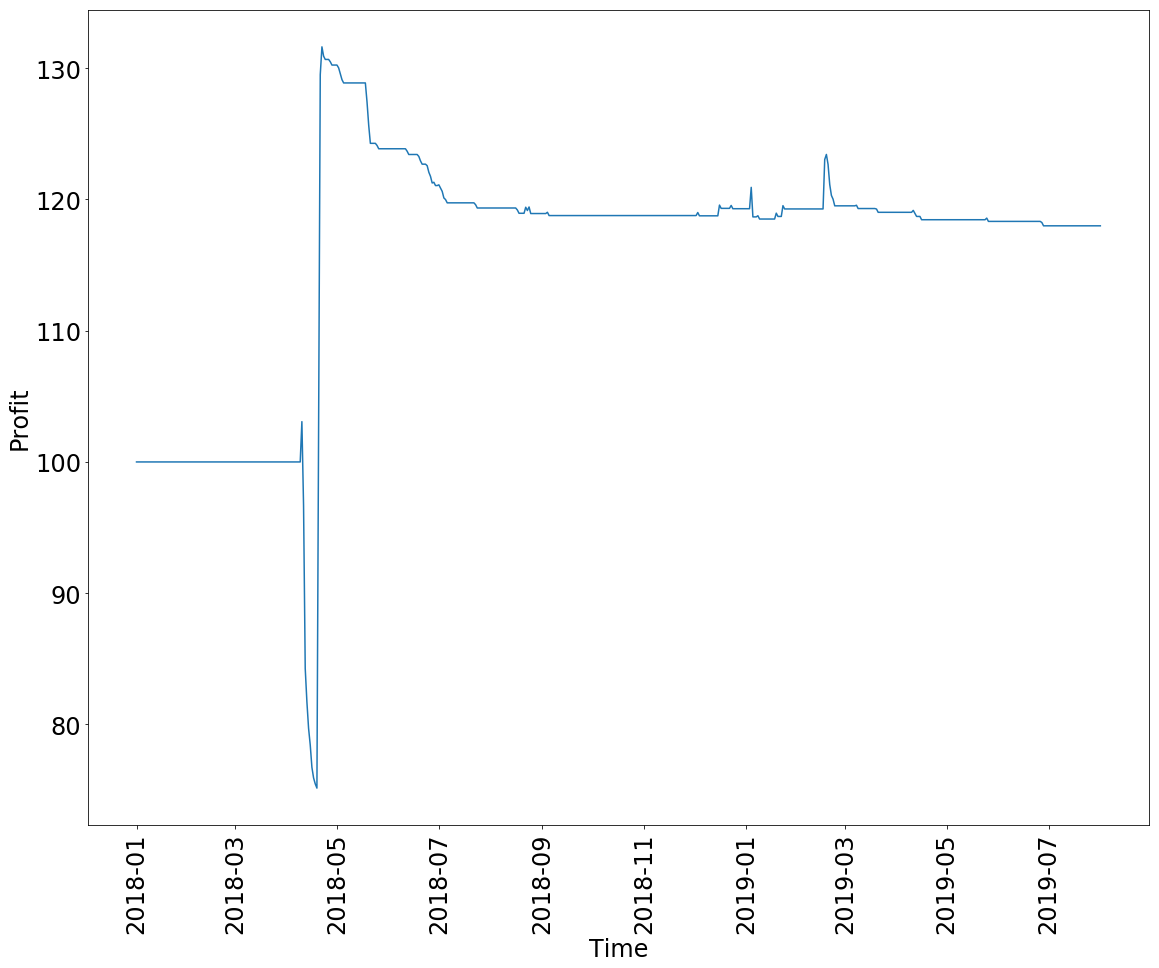

117.991857696


In [27]:
# now a algorithmus which calculates lead-lag correlation for every pair of currencies
# 100 day moving average is used like it is common in stock markets

dollar = 100
crypto = 0

correlationBookCrypto = {}
correlationBookDollar = {}

for currency1 in data.columns:
    correlationBookCrypto[currency1] = {}
    correlationBookDollar[currency1] = {}
    for currency2 in data.columns:
        correlationBookCrypto[currency1][currency2] = 0
        correlationBookDollar[currency1][currency2] = 0.25

rollingSignalCorrelation = data.rolling(100).corr()

profitGraph = pd.DataFrame(data=np.zeros(len(data)), columns=['profit'], index=data.index)

for index in data.index:
    for currency1 in rollingSignalCorrelation.columns:
        for currency2 in rollingSignalCorrelation.columns:
            if rollingSignalCorrelation[currency1][index][currency2] < rollingSignalCorrelation[currency2].shift(1)[index][currency1] and rollingSignalCorrelation[currency1][index][currency2] > 0 and (correlationBookDollar[currency1][currency2] != 0):
                if data[currency2][index] > data[currency2].shift(1)[index]:
                    correlationBookCrypto[currency1][currency2] = correlationBookDollar[currency1][currency2] / data[currency1][index] * 0.998
                    correlationBookDollar[currency1][currency2] = 0
            elif correlationBookCrypto[currency1][currency2] != 0:
                correlationBookDollar[currency2][currency1] = correlationBookCrypto[currency2][currency1] * data[currency2][index] * 0.999
                correlationBookCrypto[currency2][currency1] = 0
                
    sum1 = 0

    for currency1 in data.columns:
        for currency2 in data.columns:
            sum1 += correlationBookCrypto[currency1][currency2] * data[currency1][-1] * 0.999
            sum1 += correlationBookDollar[currency1][currency2]
    
    profitGraph['profit'][index] = sum1

f = plt.figure(figsize=(19, 15))

plt.plot(profitGraph)

plt.xticks(fontsize=24, rotation=90)
plt.yticks(fontsize=24)

plt.xlabel('Time', fontsize=24)
plt.ylabel('Profit', fontsize=24)

plt.show()

print(profitGraph['profit'][-1])

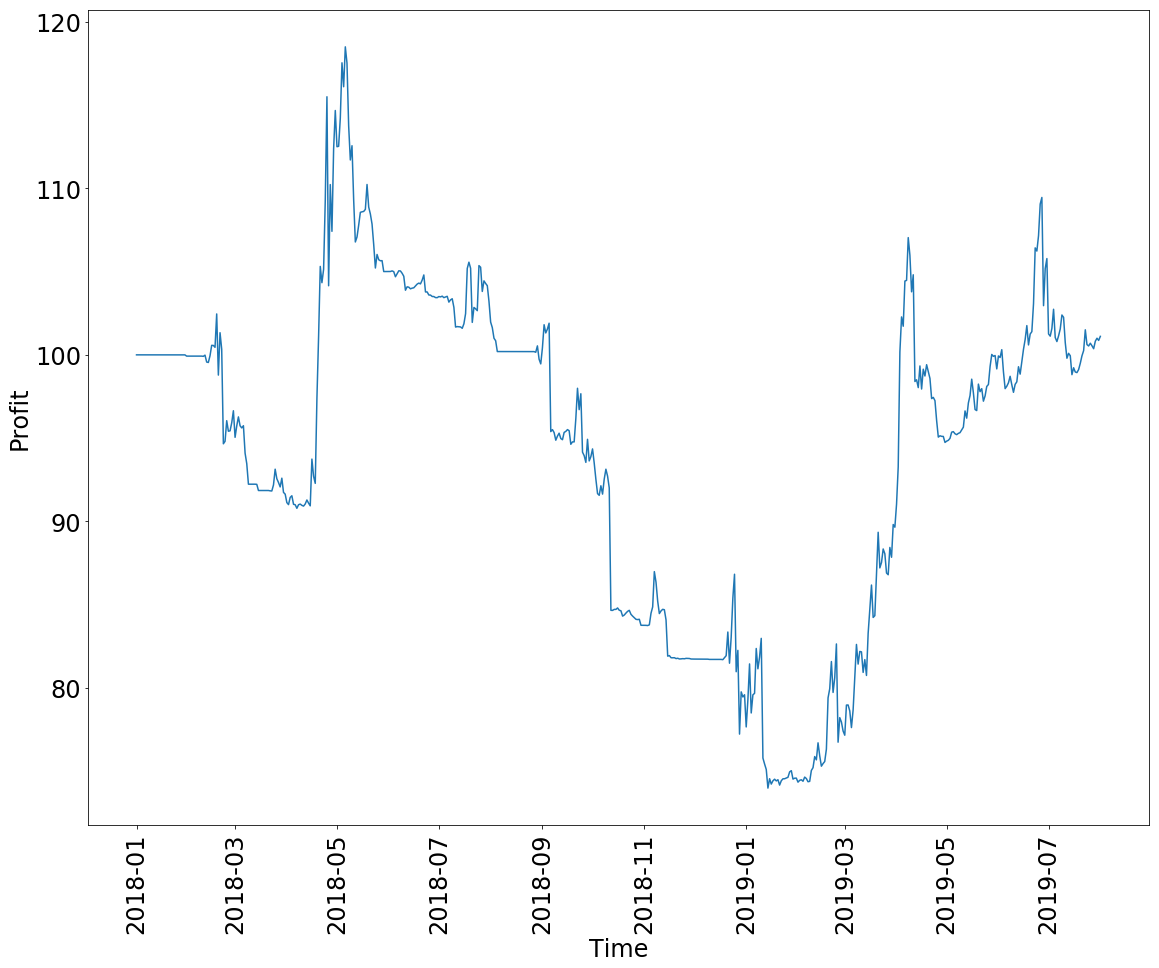

101.11031413


In [28]:
# bitcoin experiment - moving averages with addition of percentage of correlation
# 30 day moving average is used like it is common in stock markets

dollar = {}
crypto = {}

for currency in data.columns:
    dollar[currency] = 5
    crypto[currency] = 0

profitGraph = pd.DataFrame(data=np.zeros(len(data)), columns=['profit'], index=data.index)

for index in data.index:
    for currency in data.columns:
        selection = data[currency]
        if ((selection[index] > selection.rolling(30).mean()[index]) and (crypto[currency] == 0)):
            corr = selection.rolling(30).corr(data['bitcoin'].rolling(30))[index]
            if (corr > 0):
                crypto[currency] = dollar[currency] / selection[index] * corr
                dollar[currency] = dollar[currency] - selection[index] * crypto[currency]
                crypto[currency] *= 0.998

        if ((selection[index] < selection.rolling(30).mean()[index]) and (crypto[currency] != 0)):
            dollar[currency] += selection[index] * crypto[currency] * 0.999
            crypto[currency] = 0
            
        profitGraph['profit'][index] += dollar[currency] + (0 if np.isnan(selection[index]) else selection[index]) * crypto[currency] * 0.999

f = plt.figure(figsize=(19, 15))

plt.plot(profitGraph)

plt.xticks(fontsize=24, rotation=90)
plt.yticks(fontsize=24)

plt.xlabel('Time', fontsize=24)
plt.ylabel('Profit', fontsize=24)

plt.show()

print(profitGraph['profit'][-1])

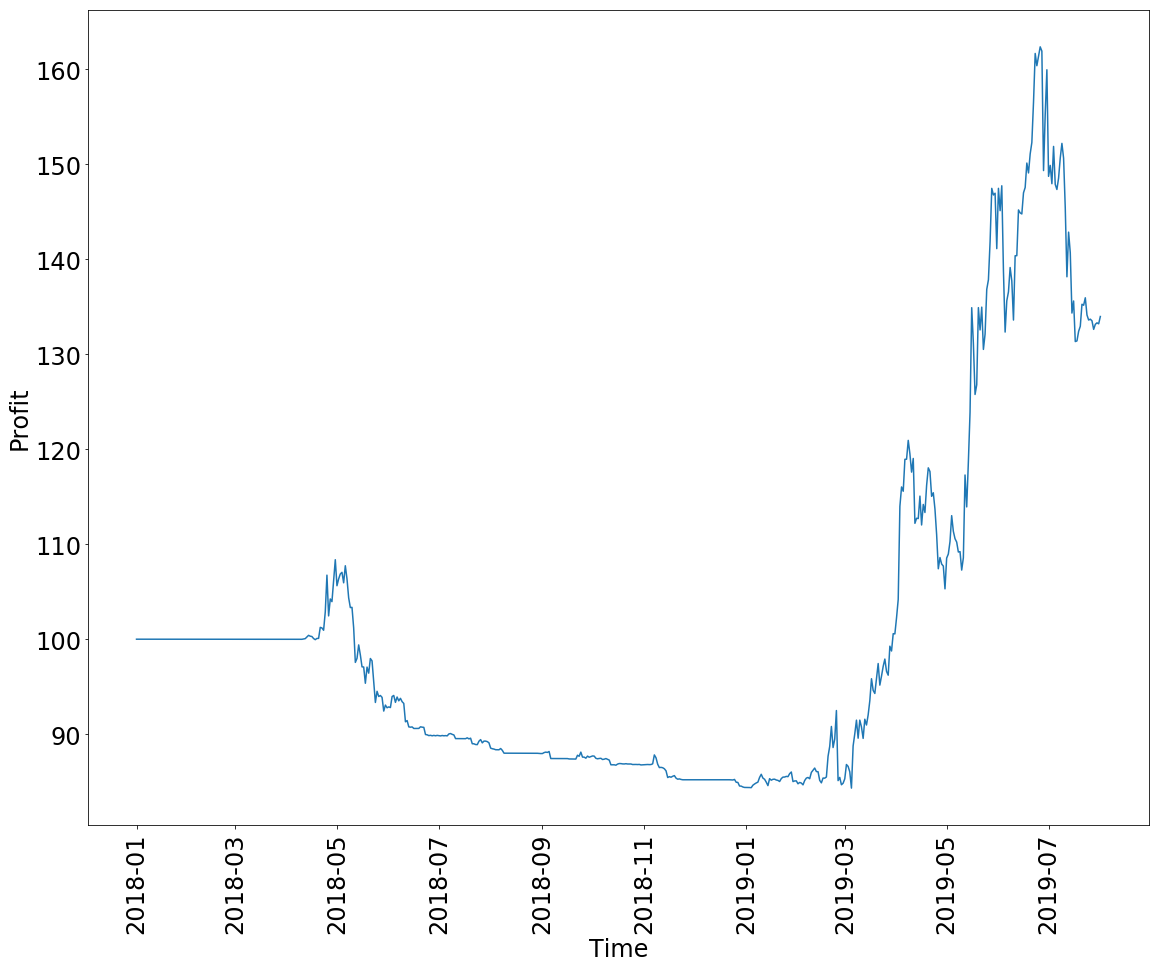

133.964256544


In [29]:
# bitcoin experiment - moving averages with addition of percentage of correlation
# 100 day moving average is used like it is common in stock markets

dollar = {}
crypto = {}

for currency in data.columns:
    dollar[currency] = 5
    crypto[currency] = 0

profitGraph = pd.DataFrame(data=np.zeros(len(data)), columns=['profit'], index=data.index)

for index in data.index:
    for currency in data.columns:
        selection = data[currency]
        if ((selection[index] > selection.rolling(100).mean()[index]) and (crypto[currency] == 0)):
            corr = selection.rolling(100).corr(data['bitcoin'].rolling(100))[index]
            if (corr > 0):
                crypto[currency] = dollar[currency] / selection[index] * corr
                dollar[currency] = dollar[currency] - selection[index] * crypto[currency]
                crypto[currency] *= 0.998

        if ((selection[index] < selection.rolling(100).mean()[index]) and (crypto[currency] != 0)):
            dollar[currency] += selection[index] * crypto[currency] * 0.999
            crypto[currency] = 0
            
        profitGraph['profit'][index] += dollar[currency] + (0 if np.isnan(selection[index]) else selection[index]) * crypto[currency] * 0.999

f = plt.figure(figsize=(19, 15))

plt.plot(profitGraph)

plt.xticks(fontsize=24, rotation=90)
plt.yticks(fontsize=24)

plt.xlabel('Time', fontsize=24)
plt.ylabel('Profit', fontsize=24)

plt.show()

print(profitGraph['profit'][-1])

In [30]:
def printAutoCorrelation(data, title):
    f = plt.figure(figsize=(19, 15))

    plt.acorr(data)
    
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    
    plt.xlabel('Shift', fontsize=24)
    plt.ylabel('Correlation', fontsize=24)

    plt.title(title, fontsize=24)

    plt.show()

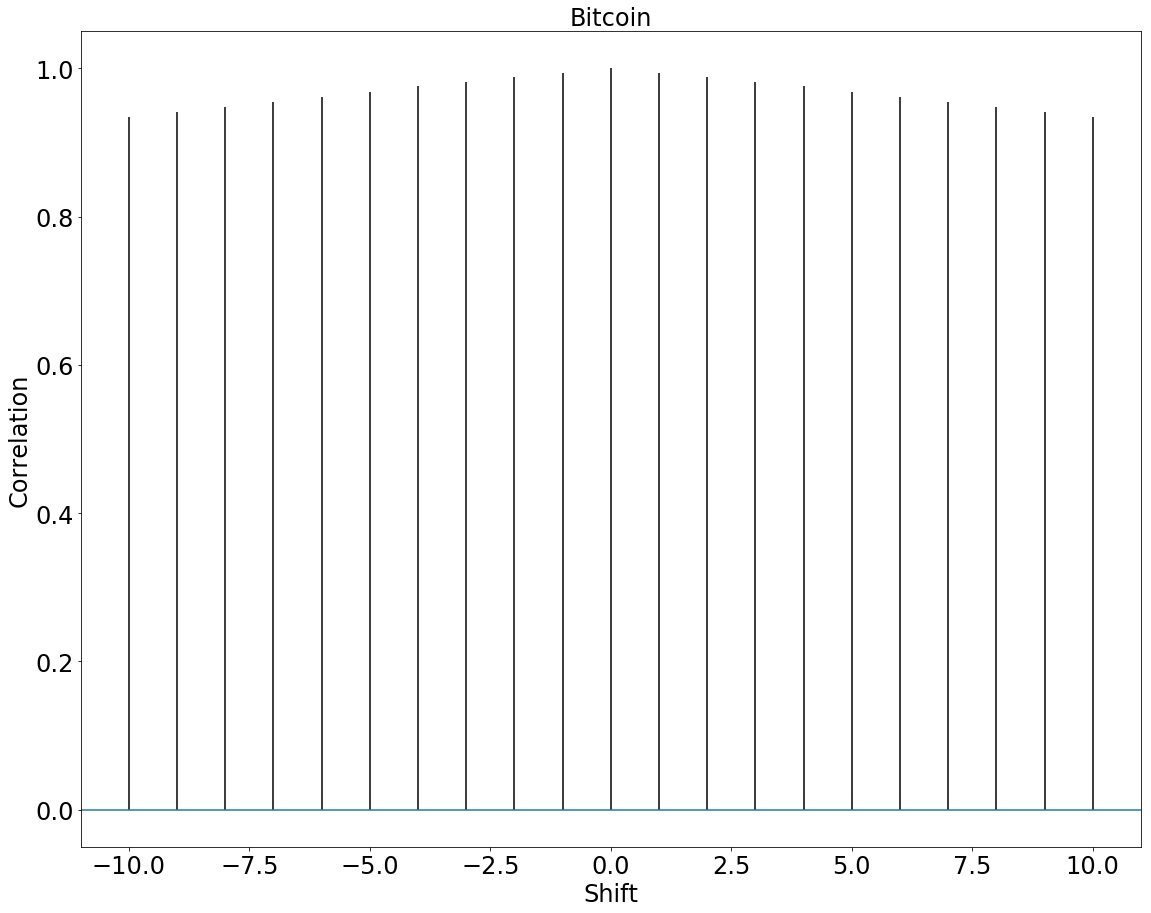

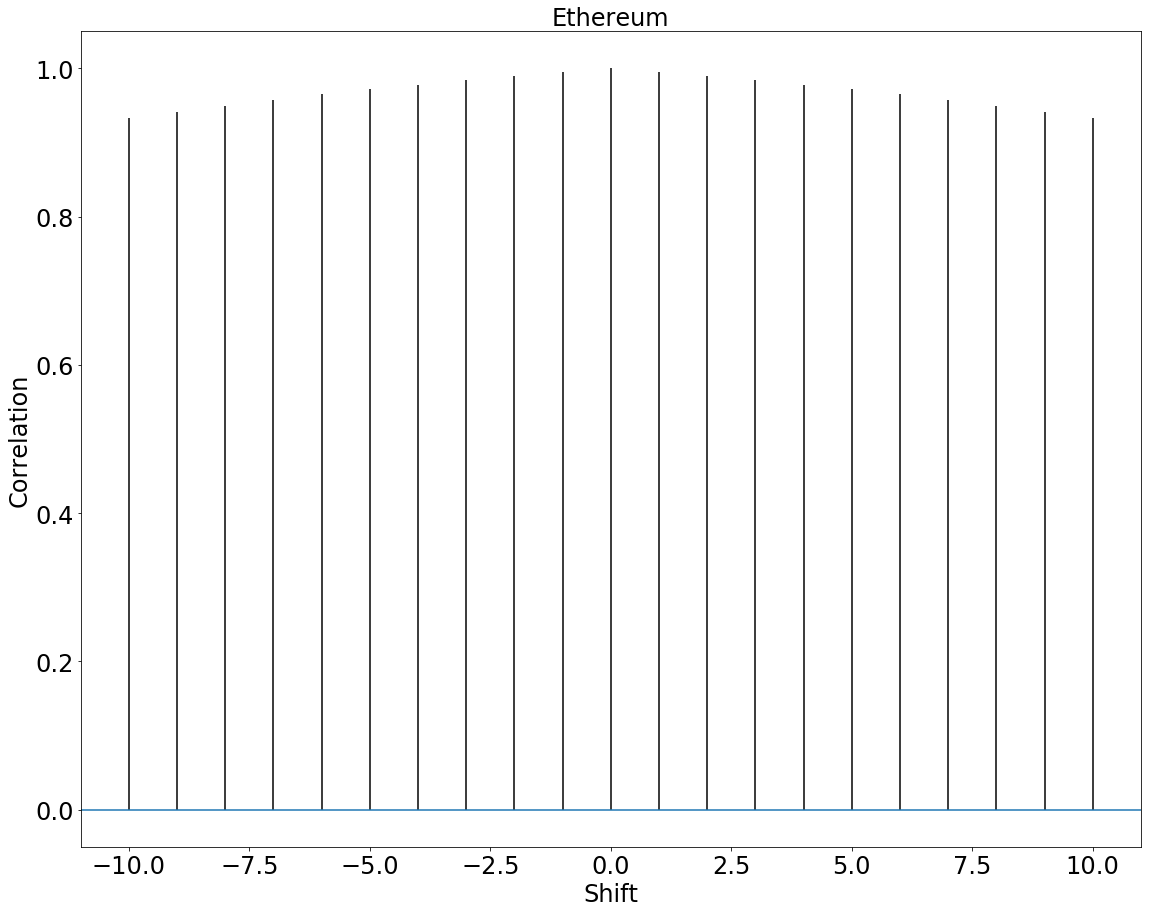

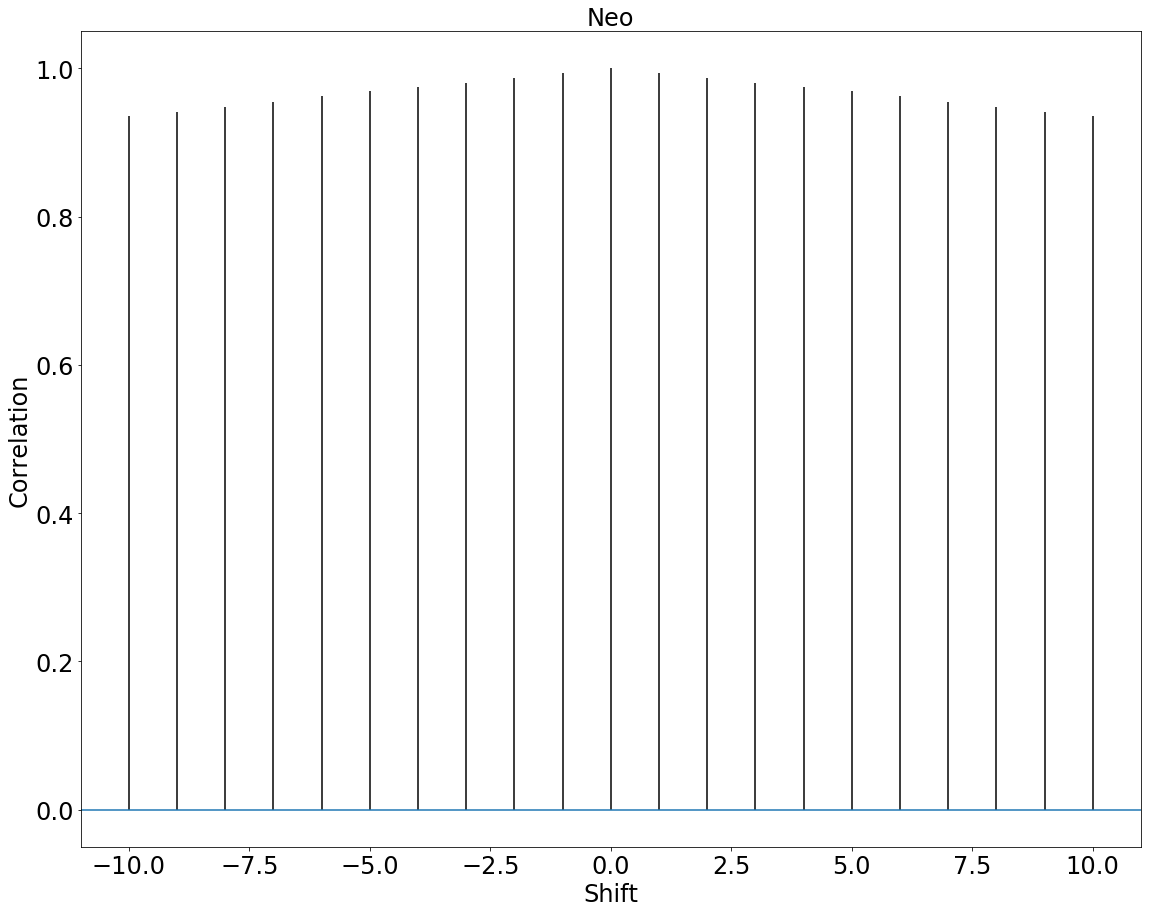

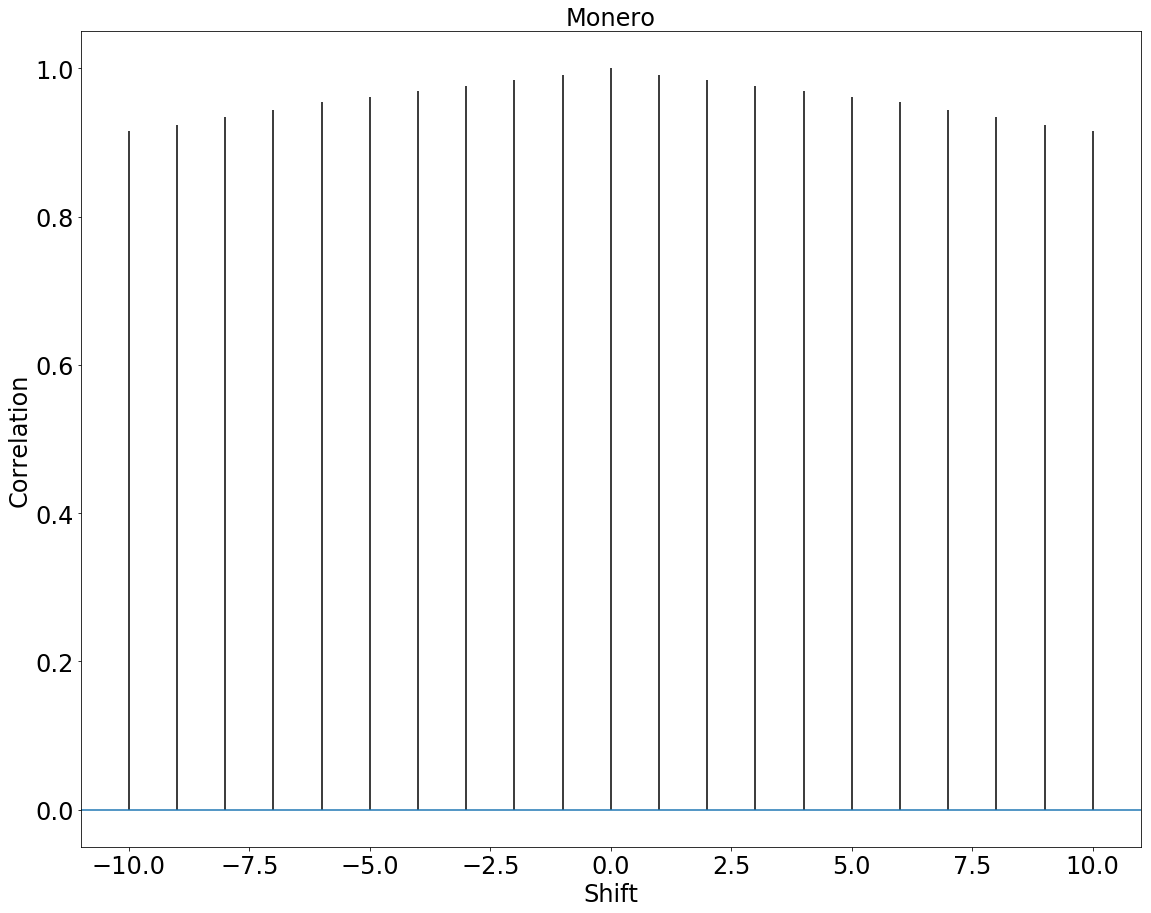

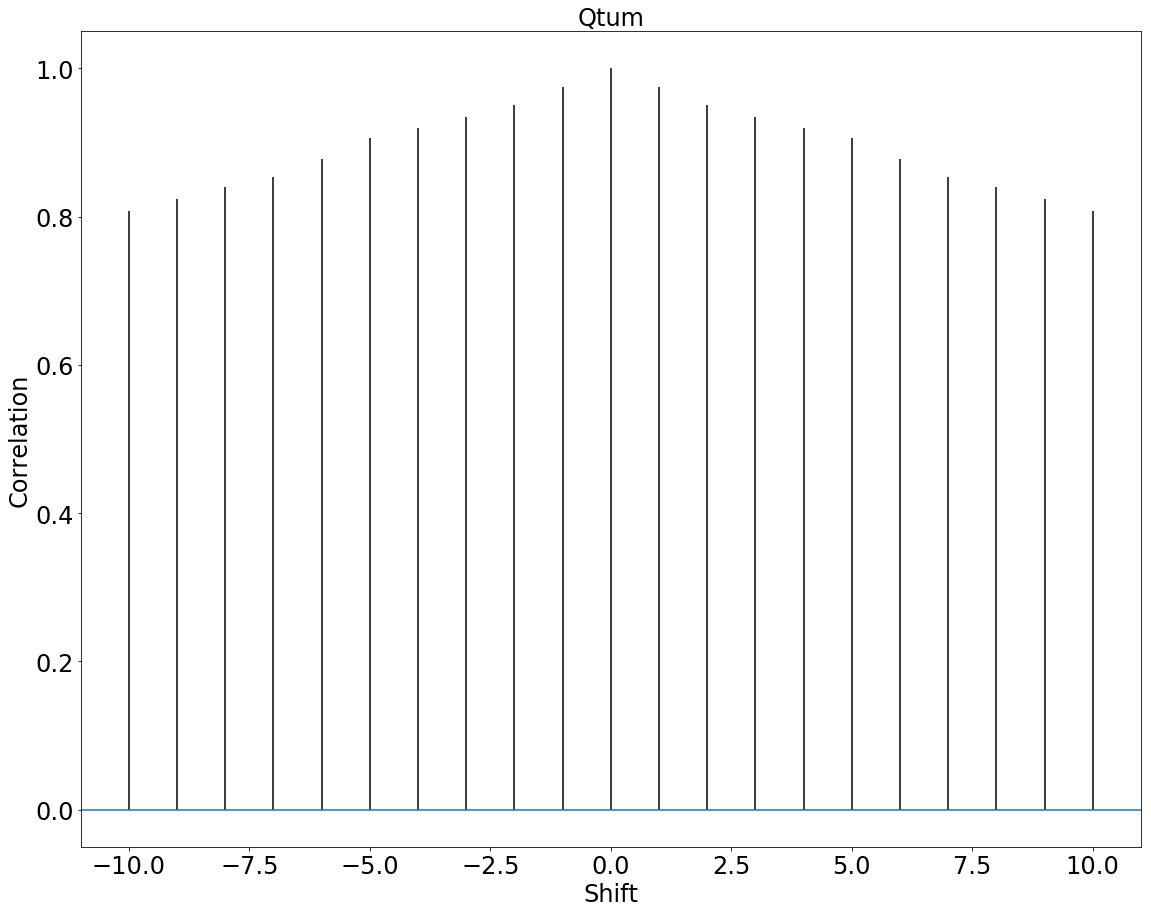

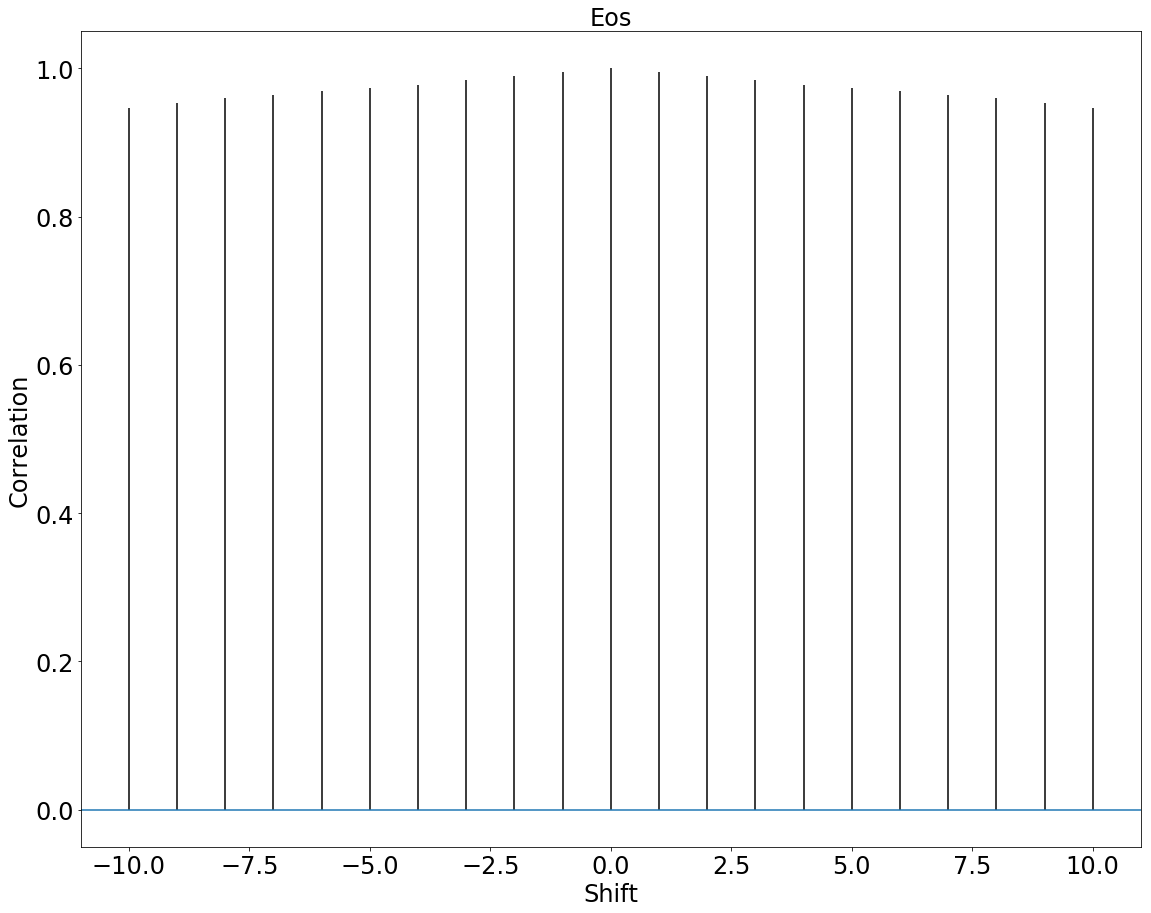

In [31]:
printAutoCorrelation(data['bitcoin'], 'Bitcoin')
printAutoCorrelation(data['ethereum'], 'Ethereum')
printAutoCorrelation(data['neo'], 'Neo')
printAutoCorrelation(data['monero'], 'Monero')
printAutoCorrelation(data['qtum'], 'Qtum')
printAutoCorrelation(data['eos'], 'Eos')